# General preprocessing for all time series (X, Y, Z)

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor
from numpy import asarray
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from matplotlib.dates import DateFormatter

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
train_data.min()

x   -1239
y   -1019
z   -1001
dtype: int64

In [ ]:
train_data

,x,y,z
0,-24,749,-626
1,-206,930,-63
2,-139,763,-577
3,-503,441,-557
4,-278,705,-396
...,...,...,...
144906,559,-803,-294
144907,559,-803,-294
144908,559,-802,-295
144909,559,-803,-294


In [ ]:
# checking empty values
print(train_data.isnull().sum())
print(test_data.isnull().sum())

x    0
y    0
z    0
dtype: int64
x    0
y    0
z    0
dtype: int64


In [ ]:
# normalization function
def normalize(data):
  result = data
  for i in ['x','y','z']:
    values = data[i].values
    values = values.reshape((len(values), 1))
    # train the normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    result[i] = normalized
  return result

In [ ]:
# normalization
norm_train_data = normalize(train_data)
norm_test_data = normalize(test_data)
#inversed = scaler.inverse_transform(normalized)  

In [ ]:
norm_train_data

,x,y,z
0,0.533363,0.843109,0.184456
1,0.453468,0.929423,0.461387
2,0.482880,0.849785,0.208559
3,0.323090,0.696233,0.218396
4,0.421861,0.822127,0.297590
...,...,...,...
144906,0.789289,0.103004,0.347762
144907,0.789289,0.103004,0.347762
144908,0.789289,0.103481,0.347270
144909,0.789289,0.103004,0.347762


In [ ]:
norm_test_data

,x,y,z
0,0.813943,0.102564,0.541047
1,0.814414,0.103550,0.540566
2,0.803109,0.098619,0.478157
3,0.757890,0.073964,0.434470
4,0.754122,0.069527,0.437830
...,...,...,...
148366,0.996703,0.467949,0.557369
148367,0.996703,0.467949,0.557369
148368,0.996703,0.467949,0.557369
148369,0.996703,0.467949,0.557369


In [ ]:
# creating dataindex column
date_today = datetime.now()
data_index_train = pd.DataFrame({'timestamp':pd.date_range(date_today, periods=len(norm_train_data), freq='10S')})
data_index_test = pd.DataFrame({'timestamp':pd.date_range(date_today, periods=len(norm_test_data), freq='10S')})

In [ ]:
data_index_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144911 entries, 0 to 144910
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  144911 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.1 MB


In [ ]:
norm_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144911 entries, 0 to 144910
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       144911 non-null  float64
 1   y       144911 non-null  float64
 2   z       144911 non-null  float64
dtypes: float64(3)
memory usage: 3.3 MB


In [ ]:
norm_train_data['timestamp'] = data_index_train
norm_test_data['timestamp'] = data_index_test

In [ ]:
# create df for each timeseries x,y,z from train data
x_train = norm_train_data.drop(['y','z'],axis = 1)
y_train = norm_train_data.drop(['x','z'],axis = 1)
z_train = norm_train_data.drop(['y','x'],axis = 1)

# set date index on timestamp col and freq=10 sec for each df
x_train = x_train.set_index('timestamp')
x_train.index.freq = "10S"
y_train = y_train.set_index('timestamp')
y_train.index.freq = "10S"
z_train = z_train.set_index('timestamp')
z_train.index.freq = "10S"

In [ ]:
# create df for each timeseries x,y,z from test data
x_test = norm_test_data.drop(['y','z'],axis = 1)
y_test = norm_test_data.drop(['x','z'],axis = 1)
z_test = norm_test_data.drop(['y','x'],axis = 1)

# set date index on timestamp col and freq=10 sec for each df
x_test = x_test.set_index('timestamp')
x_test.index.freq = "10S"
y_test = y_test.set_index('timestamp')
y_test.index.freq = "10S"
z_test = z_test.set_index('timestamp')
z_test.index.freq = "10S"

In [ ]:
# create Lag features for data function, rolling window
def lag_features(data, col, shift=1, window_size=2):
  result = data
  result['%s_lag1' % col] = result[col].shift(shift)
  window = result['%s_lag1' % col].rolling(window=window_size)
  means = window.mean()
  result['%s_mean' % col] = means
  return result, result

In [ ]:
# Multiplicative Seasonal Decomposition function
def mul_decomp(data):
  mul_result = seasonal_decompose(data, model='Multiplicative', freq = 6)
  mul_result.plot()

In [ ]:
# Adfuller test function
# It returns a P-value, if p<0.5 : Data is Stationary , p>0.5 : Data is Not Stationary
def adfuller_test(data):
  adfuller_result = adfuller(data, autolag='AIC')
  print(f'ADF Statistic: {adfuller_result[0]}')
  print(f'p-value: {adfuller_result[1]}')
  for key, value in adfuller_result[4].items():
      print('Critial Values:')
      print(f'   {key}, {value}')

In [ ]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:
def out_of_sample_forecast(data, to_pred, sample_size):
  init_row = data[-sample_size:]
  # transform the time series data into supervised learning
  train = series_to_supervised(data,sample_size)
  # split into input and output columns
  trainX, trainy = train[:, :-1], train[:, -1]
  # fit model
  model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, eval_metric="mae")
  model.fit(trainX, trainy)
  preds = []
  data_app = data
  for i in range(to_pred):
    # construct an input for a new preduction
    row = data_app[-sample_size:]
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    data_app = list(np.append(data_app, yhat[0]))
    preds.append(yhat[0])
  print("Result for sample of size %d:" % sample_size)
  print('Input: %s, Predicted: %s' % (init_row, preds))
  print("MAE: %f\n" % mean_absolute_error(data_app[-(sample_size+to_pred):-sample_size],preds))
  return init_row, preds

In [ ]:
def plot_loss(model):
  # retrieve performance metrics
  rcParams["figure.figsize"] = 40,10
  results = model.evals_result()
  epochs = len(results['validation_0']['mae'])
  x_axis = range(0, epochs)
  # plot log loss
  fig, ax = pyplot.subplots()
  ax.plot(x_axis, results['validation_0']['mae'], label='Train')
  ax.plot(x_axis, results['validation_1']['mae'], label='Test')
  ax.legend()
  pyplot.ylabel('MAE Loss')
  pyplot.title('XGBoost MAE Loss')
  pyplot.show()

# Time series **X**

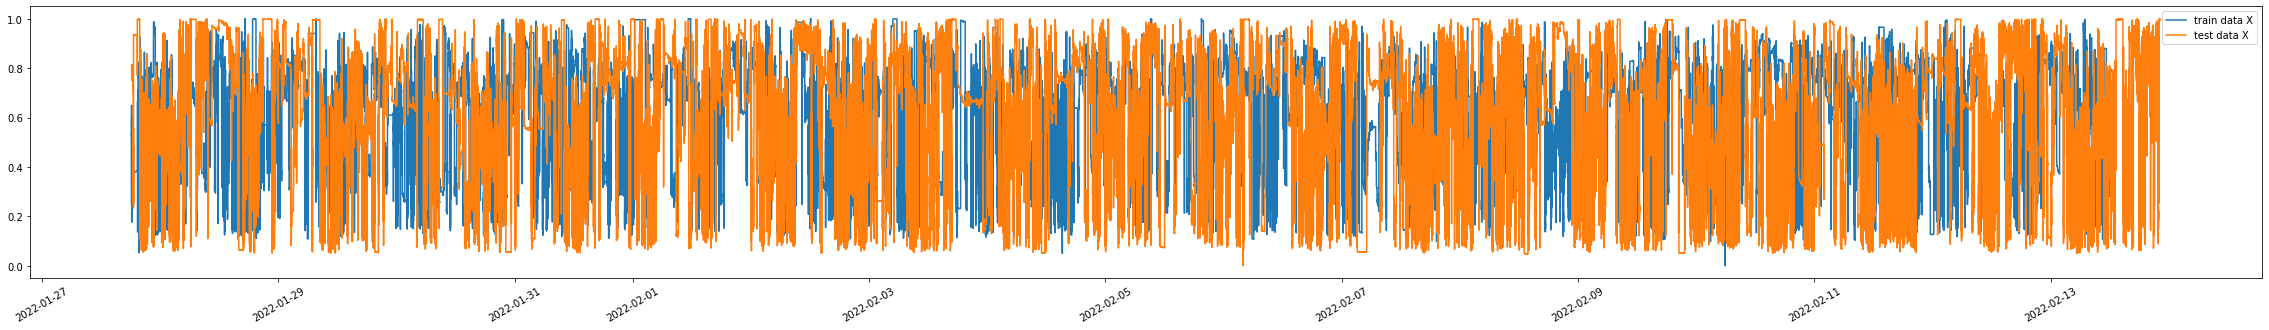

In [ ]:
rcParams["figure.figsize"] = 40,5
plt.plot(x_train["x"], label = "train data X")
plt.plot(x_test["x"], label = "test data X")
plt.xticks(rotation=30)
plt.legend()
plt.show()
# horizontal/stationary trend

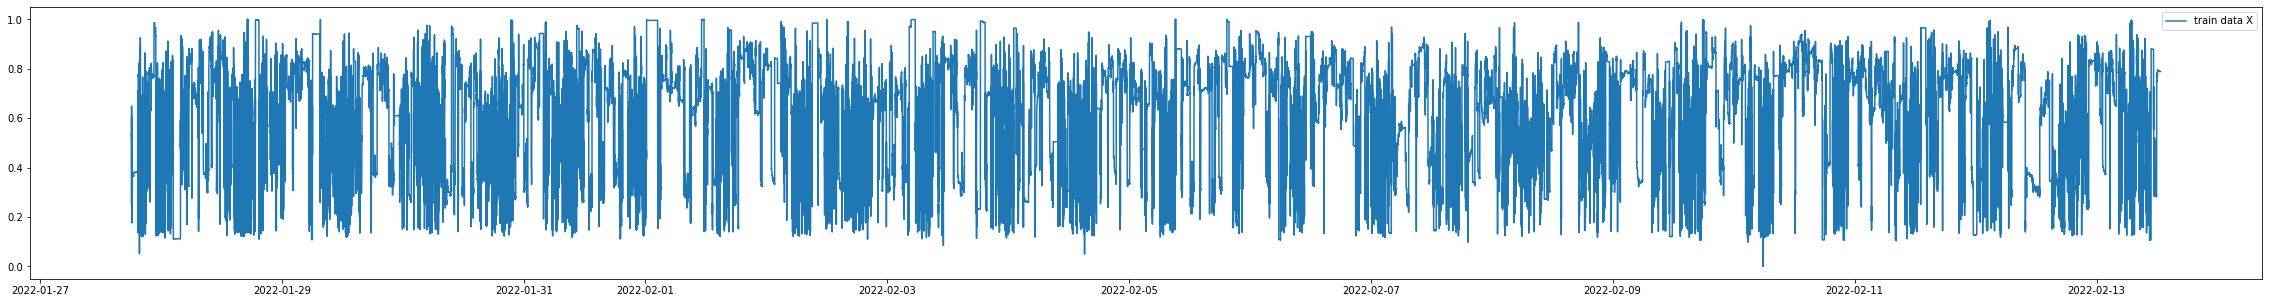

In [ ]:
plt.plot(x_train["x"], label = "train data X")
plt.legend()
plt.show()

In [ ]:
x_train, x_train_out = lag_features(x_train, 'x')
x_test, x_test_out = lag_features(x_test, 'x')

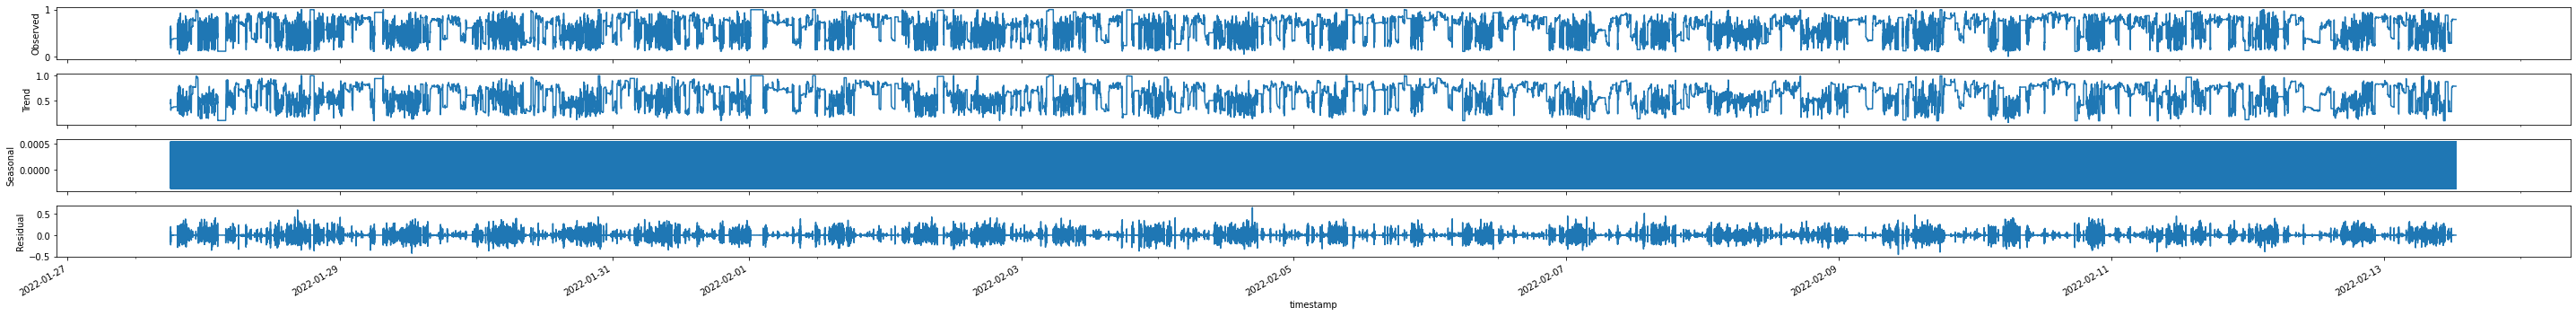

In [ ]:
mul_decomp(x_train['x'])

In [ ]:
adfuller_test(x_train['x'])
# Data is Stationary, p=0 for x

ADF Statistic: -20.533172681566217
p-value: 0.0
Critial Values:
   1%, -3.430395150798503
Critial Values:
   5%, -2.8615599560136378
Critial Values:
   10%, -2.5667806218758895


In [ ]:
# Separating the data to x_train, y_train, x_test and y_test — Input(x) and Output (y)
sx_train_X, sy_train_X = x_train.drop(['x'], axis=1), x_train['x']
sx_test_X, sy_test_X = x_test.drop(['x'], axis=1), x_test['x']

In [ ]:
# model
model_x = xgb.XGBRegressor(n_estimators=1000)
model_x.fit(sx_train_X, sy_train_X,
        eval_set=[(sx_train_X, sy_train_X), (sx_test_X, sy_test_X)], eval_metric="mae",
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True) 

[18:11:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.188295	validation_1-mae:0.231459
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.171543	validation_1-mae:0.211631
[2]	validation_0-mae:0.156563	validation_1-mae:0.194289
[3]	validation_0-mae:0.143171	validation_1-mae:0.178327
[4]	validation_0-mae:0.131175	validation_1-mae:0.164151
[5]	validation_0-mae:0.120414	validation_1-mae:0.151478
[6]	validation_0-mae:0.110814	validation_1-mae:0.140015
[7]	validation_0-mae:0.102221	validation_1-mae:0.129919
[8]	validation_0-mae:0.094481	validation_1-mae:0.120685
[9]	validation_0-mae:0.087559	validation_1-mae:0.112316
[10]	validation_0-mae:0.081368	validation_1-mae:0.104842
[11]	validation_0-mae:0.0758	validation_1-mae:0.098173
[12]	validation_0-mae:0.070801	validation_1-

XGBRegressor(n_estimators=1000)

In [ ]:
preds_x = pd.DataFrame(model_x.predict(sx_test_X))

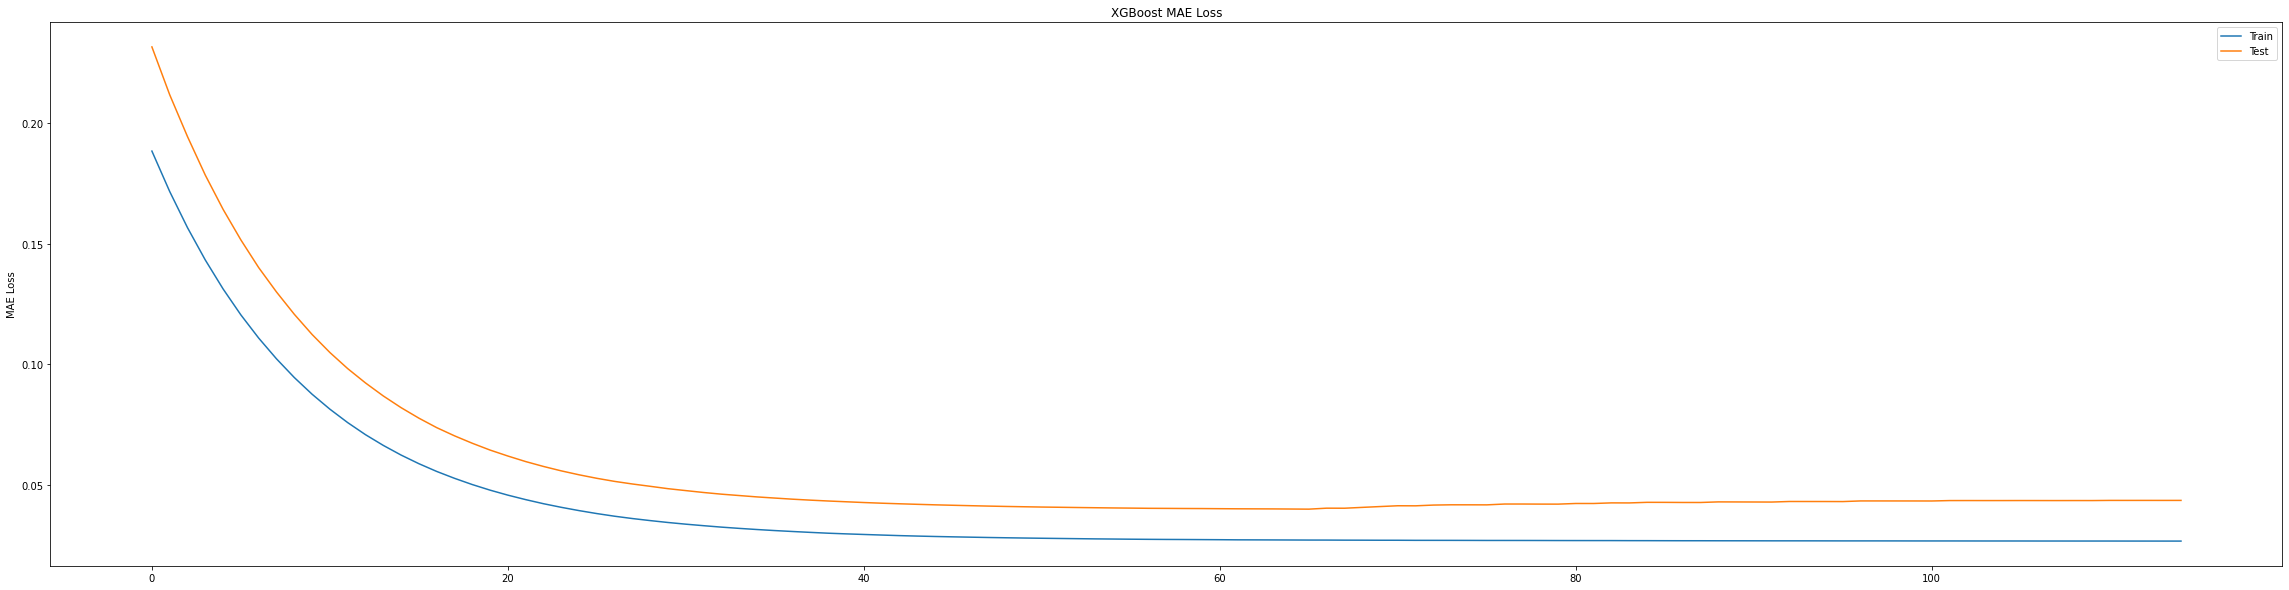

In [ ]:
plot_loss(model_x)

In [ ]:
print("Value of MAE for X:")
round(mean_absolute_error(sy_test_X, preds_x) * 100,2)

Value of MAE for X:


3.99

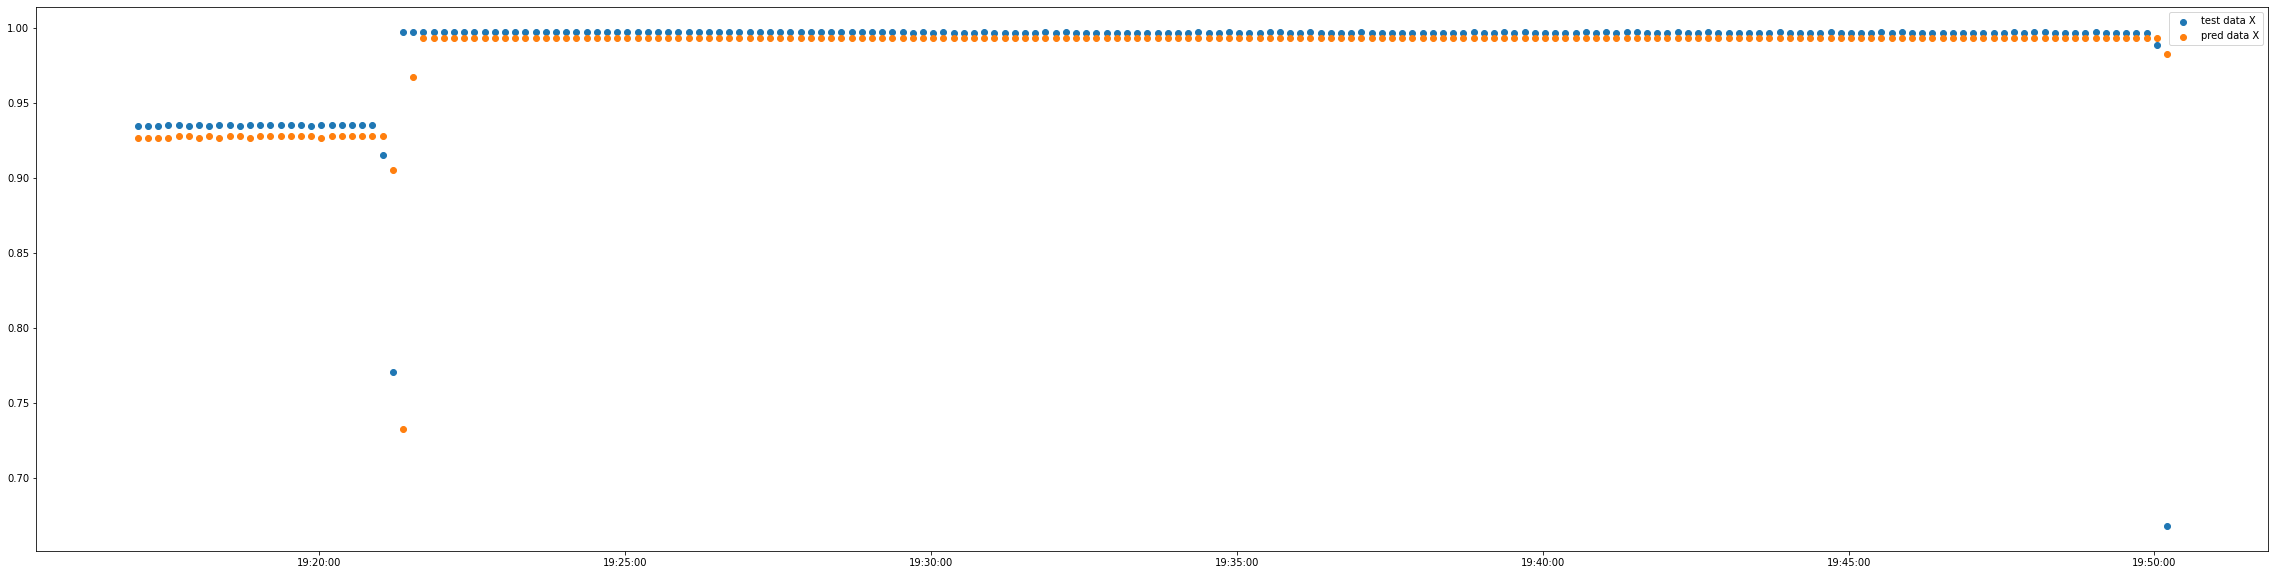

In [ ]:
myFmt = DateFormatter("%H:%M:%S")
plt.scatter(norm_test_data[400:600]['timestamp'],sy_test_X[400:600], label = "test data X")
plt.scatter(norm_test_data[400:600]['timestamp'], np.asarray(preds_x)[400:600], label = "pred data X")
plt.gca().xaxis.set_major_formatter(myFmt) # apply the format to the desired axis
plt.legend()
plt.show()

Result for sample of size 25:
Input: [0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9971738106453132, 0.9971738106453132, 0.9971738106453132, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988], Predicted: [0.9961641, 0.9943758, 0.99353826, 0.9846575, 0.9317219, 0.8735212, 0.8628417, 0.8707732, 0.86565506, 0.86057365]
MAE: 0.073462



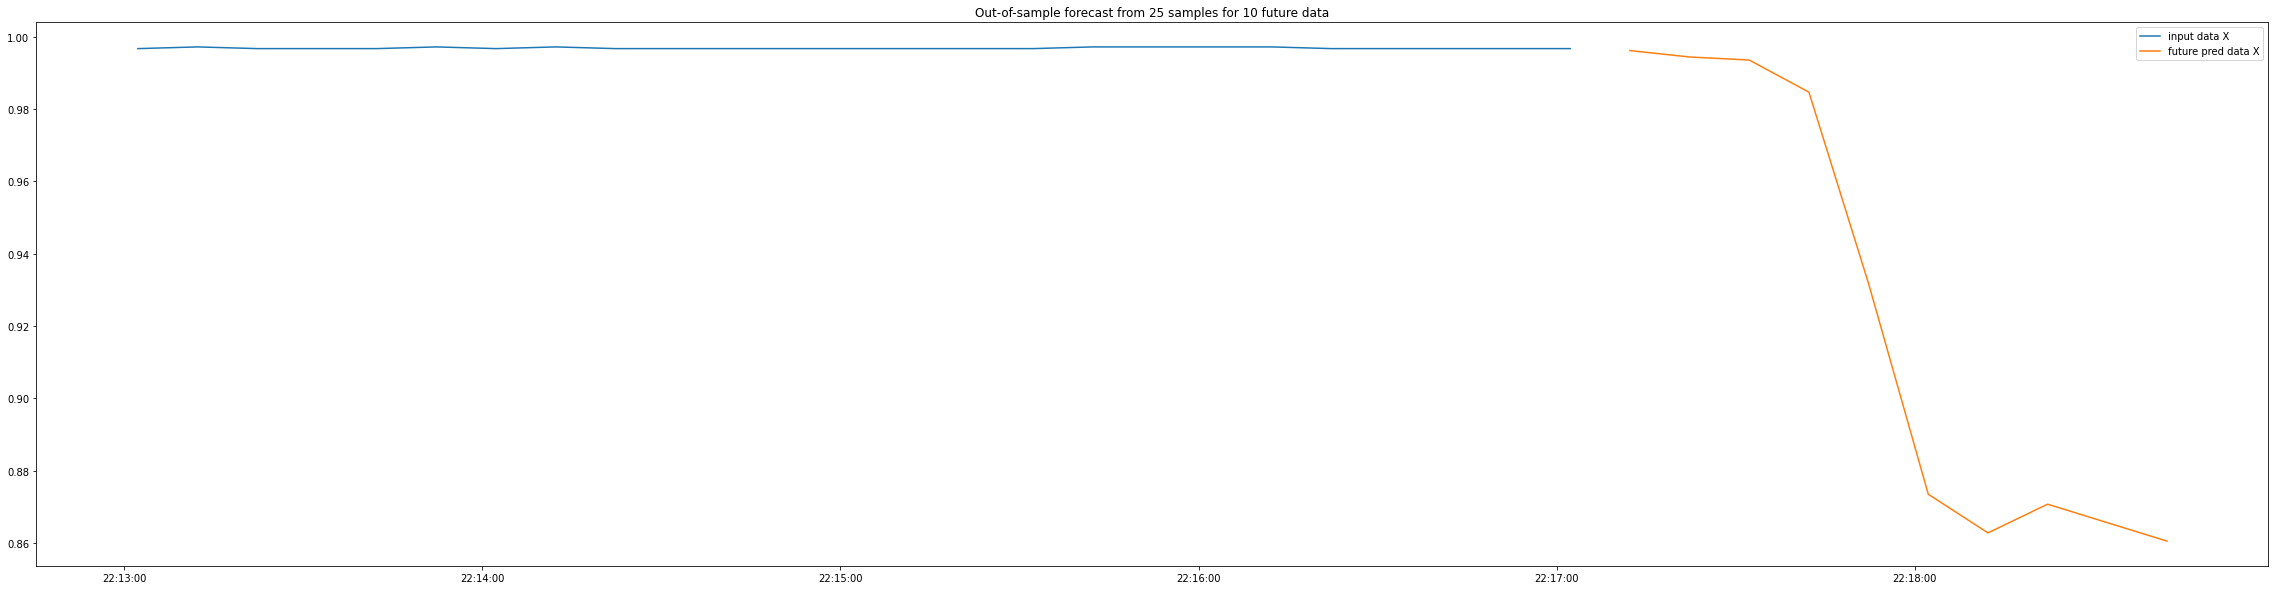

Result for sample of size 25:
Input: [0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9971738106453132, 0.9971738106453132, 0.9971738106453132, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988], Predicted: [0.9961641, 0.9943758, 0.99353826, 0.9846575, 0.9317219, 0.8735212, 0.8628417, 0.8707732, 0.86565506, 0.86057365, 0.8479397, 0.8435589, 0.84428763, 0.84306365, 0.8441304, 0.8429065, 0.8429196, 0.840264, 0.8385862, 0.8374929, 0.83038986, 0.8215801, 0.8135561, 0.8077657, 0.8045322, 0.8062881, 0.8062881, 0.809513, 0.809513, 0.8088971]
MAE: 0.134801



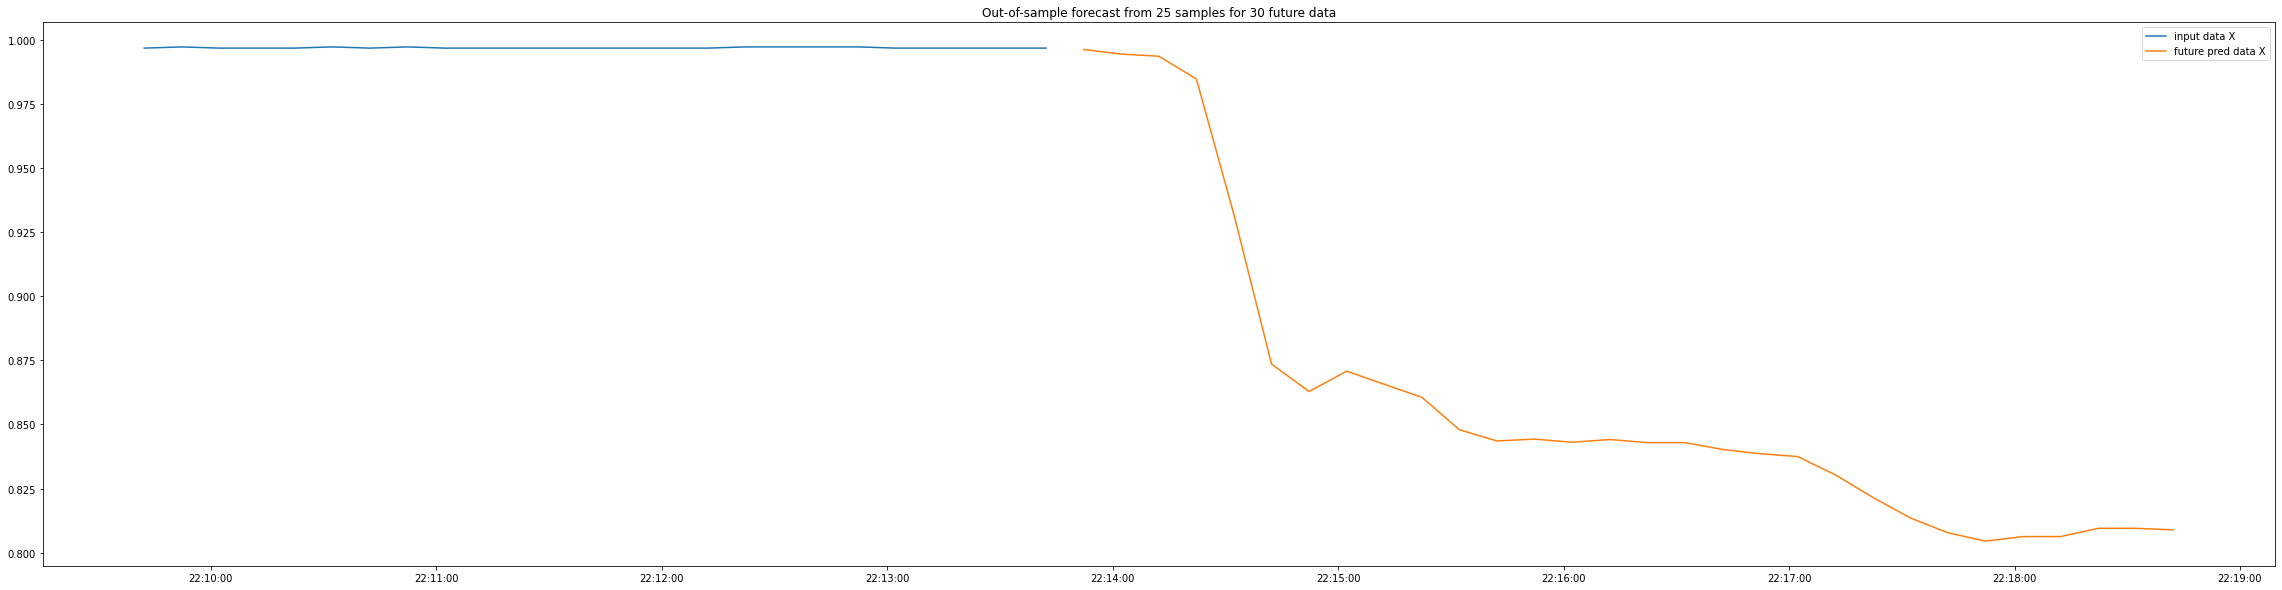

Result for sample of size 25:
Input: [0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9971738106453132, 0.9971738106453132, 0.9971738106453132, 0.9971738106453132, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988, 0.9967027790861988], Predicted: [0.9961641, 0.9943758, 0.99353826, 0.9846575, 0.9317219, 0.8735212, 0.8628417, 0.8707732, 0.86565506, 0.86057365, 0.8479397, 0.8435589, 0.84428763, 0.84306365, 0.8441304, 0.8429065, 0.8429196, 0.840264, 0.8385862, 0.8374929, 0.83038986, 0.8215801, 0.8135561, 0.8077657, 0.8045322, 0.8062881, 0.8062881, 0.809513, 0.809513, 0.8088971, 0.8088971, 0.8088971, 0.80775094, 0.80693763, 0.8076997, 0.80693763, 0.8067428, 0.8067428, 0.8067428, 0.8067428, 0.8

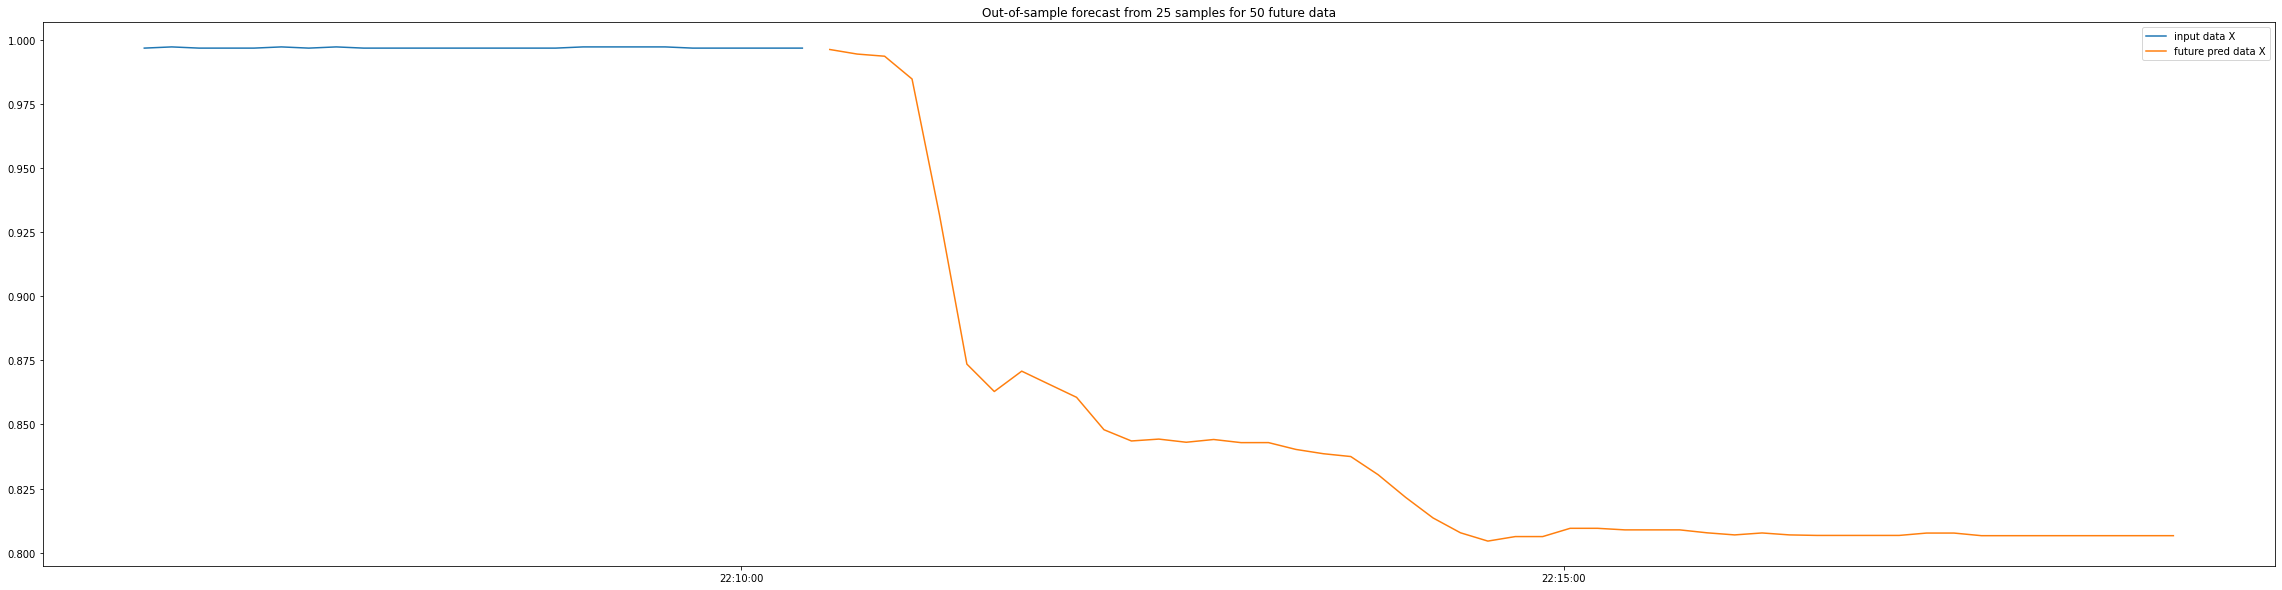

In [ ]:
from matplotlib.dates import DateFormatter
myFmt = DateFormatter("%H:%M:%S")
#  out-of-sample forecast, predicting beyond the training dataset
data = list(norm_test_data['x'].values)
sample_size = 25
for to_pred in [10,30,50]:
  input, preds = out_of_sample_forecast(data, to_pred, sample_size)
  input = [round(v,5) for v in input]
  preds = [round(v,5) for v in preds]
  plt.plot(norm_test_data[-(to_pred+sample_size):-to_pred]['timestamp'],input, label = "input data X")
  plt.plot(norm_test_data[-to_pred:]['timestamp'], preds, label = "future pred data X")
  plt.title("Out-of-sample forecast from %d samples for %d future data" % (sample_size,to_pred))
  plt.gca().xaxis.set_major_formatter(myFmt) # apply the format to the desired axis
  plt.legend()
  plt.show()

# Time series **Y**

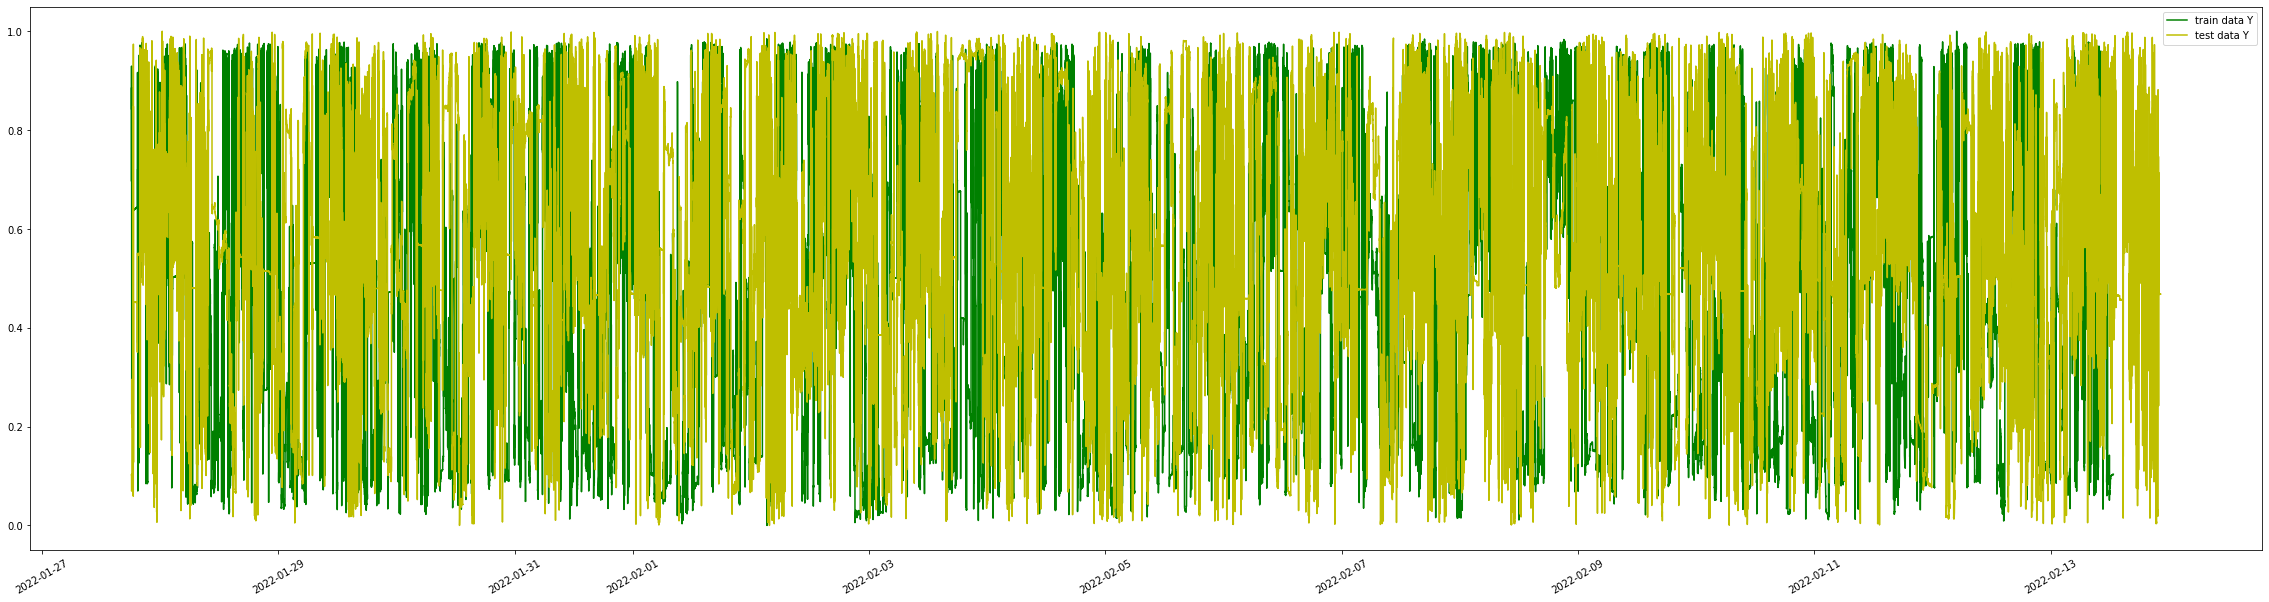

In [ ]:
plt.plot(y_train["y"], label = "train data Y", color="g")
plt.plot(y_test["y"], label = "test data Y",color="y")
plt.xticks(rotation=30)
plt.legend()
plt.show()
# horizontal/stationary trend

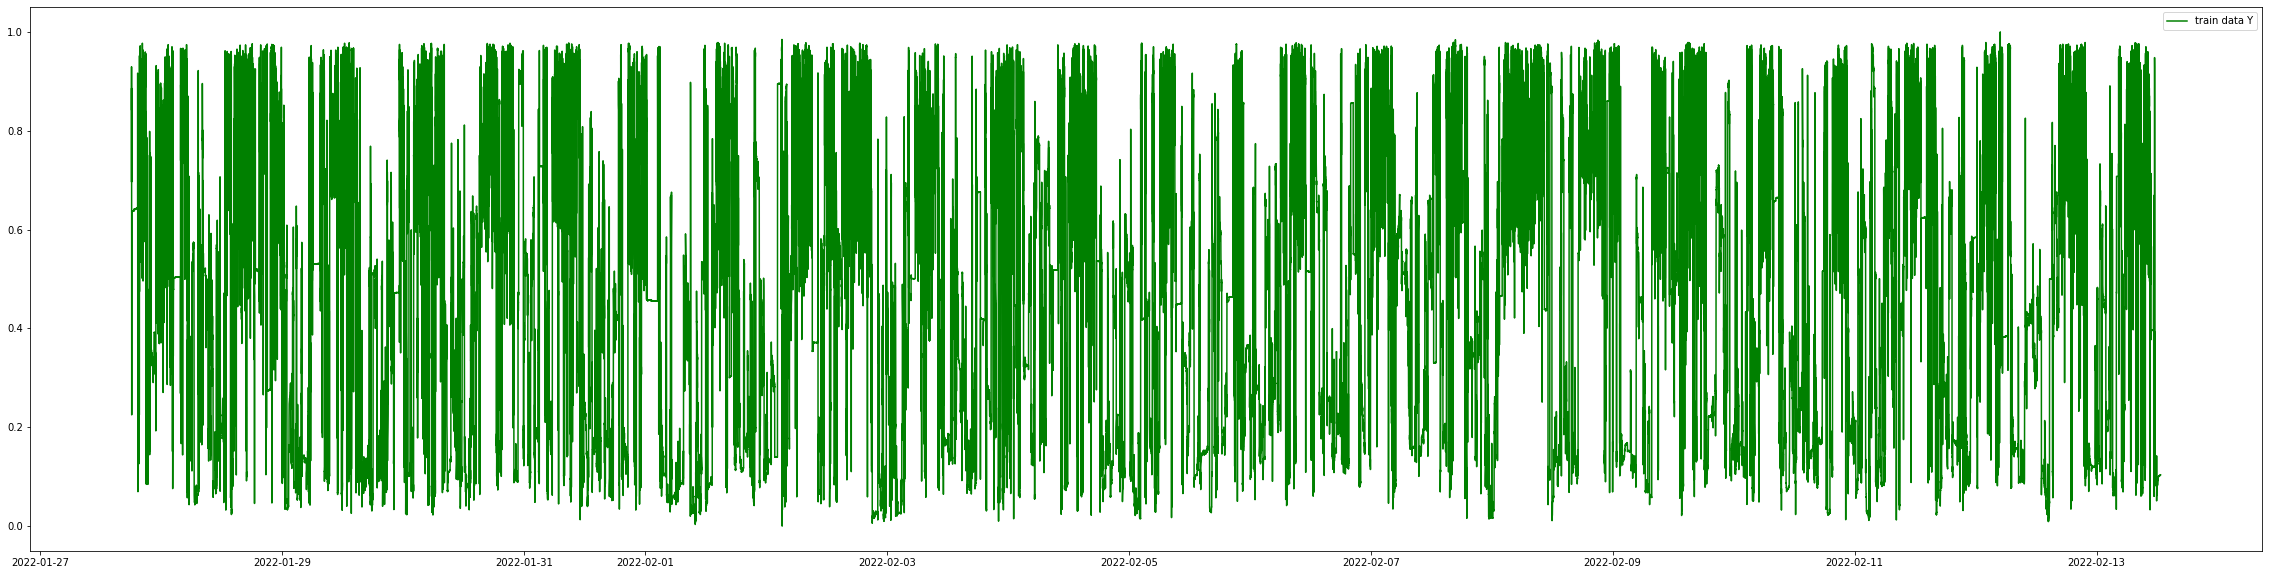

In [ ]:
plt.plot(y_train["y"], label = "train data Y", color ="g")
plt.legend()
plt.show()

In [ ]:
y_train, y_train_out = lag_features(y_train, 'y')
y_test, y_test_out = lag_features(y_test, 'y')

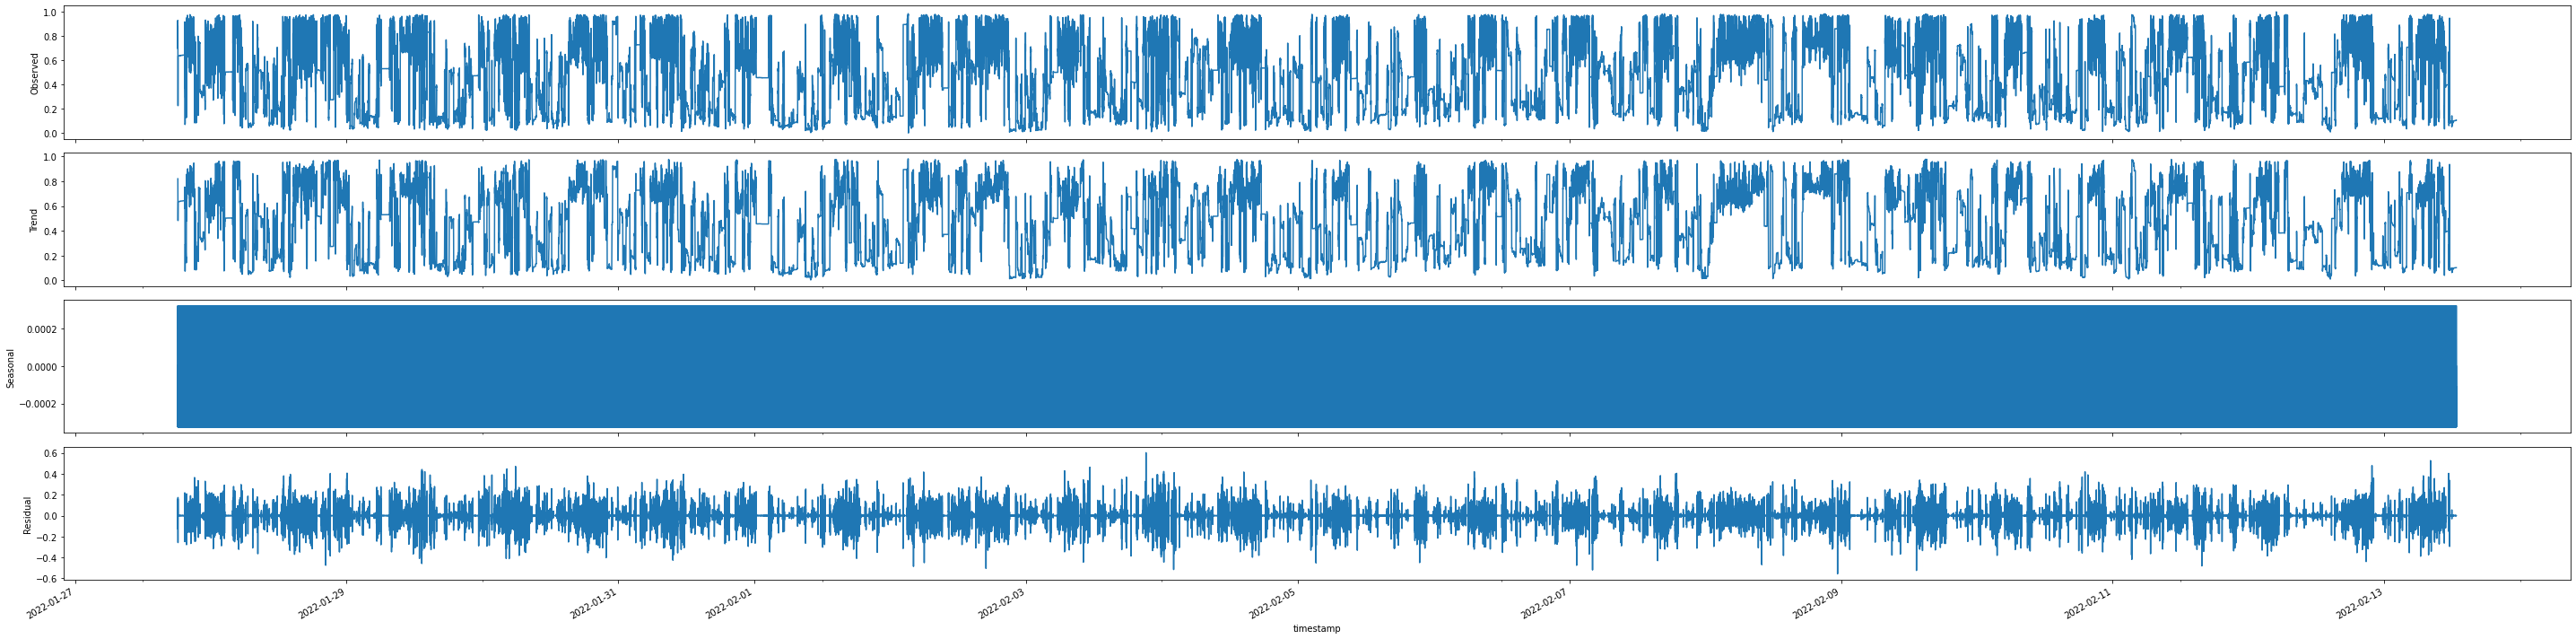

In [ ]:
mul_decomp(y_train['y'])

In [ ]:
adfuller_test(y_train['y'])

# Data is Stationary, p=4.281076662753223e-30 for y

ADF Statistic: -17.521910844822248
p-value: 4.281076662753223e-30
Critial Values:
   1%, -3.430395150798503
Critial Values:
   5%, -2.8615599560136378
Critial Values:
   10%, -2.5667806218758895


In [ ]:
# train data splitting
sx_train_Y, sy_train_Y = y_train.drop(['y'], axis=1), y_train['y']
sx_test_Y, sy_test_Y = y_test.drop(['y'], axis=1), y_test['y']

In [ ]:
# model

model_y = xgb.XGBRegressor(n_estimators=1000)
model_y.fit(sx_train_Y, sy_train_Y,
        eval_set=[(sx_train_Y, sy_train_Y), (sx_test_Y, sy_test_Y)], eval_metric="mae",
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True) 

[18:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.22478	validation_1-mae:0.185473
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.203653	validation_1-mae:0.169126
[2]	validation_0-mae:0.184772	validation_1-mae:0.154507
[3]	validation_0-mae:0.167676	validation_1-mae:0.141311
[4]	validation_0-mae:0.152431	validation_1-mae:0.129591
[5]	validation_0-mae:0.138801	validation_1-mae:0.119237
[6]	validation_0-mae:0.126558	validation_1-mae:0.11006
[7]	validation_0-mae:0.115617	validation_1-mae:0.101929
[8]	validation_0-mae:0.105907	validation_1-mae:0.094777
[9]	validation_0-mae:0.097255	validation_1-mae:0.088474
[10]	validation_0-mae:0.089507	validation_1-mae:0.08294
[11]	validation_0-mae:0.082654	validation_1-mae:0.078163
[12]	validation_0-mae:0.076547	validation_1-m

XGBRegressor(n_estimators=1000)

In [ ]:
preds_y = pd.DataFrame(model_y.predict(sx_test_Y))

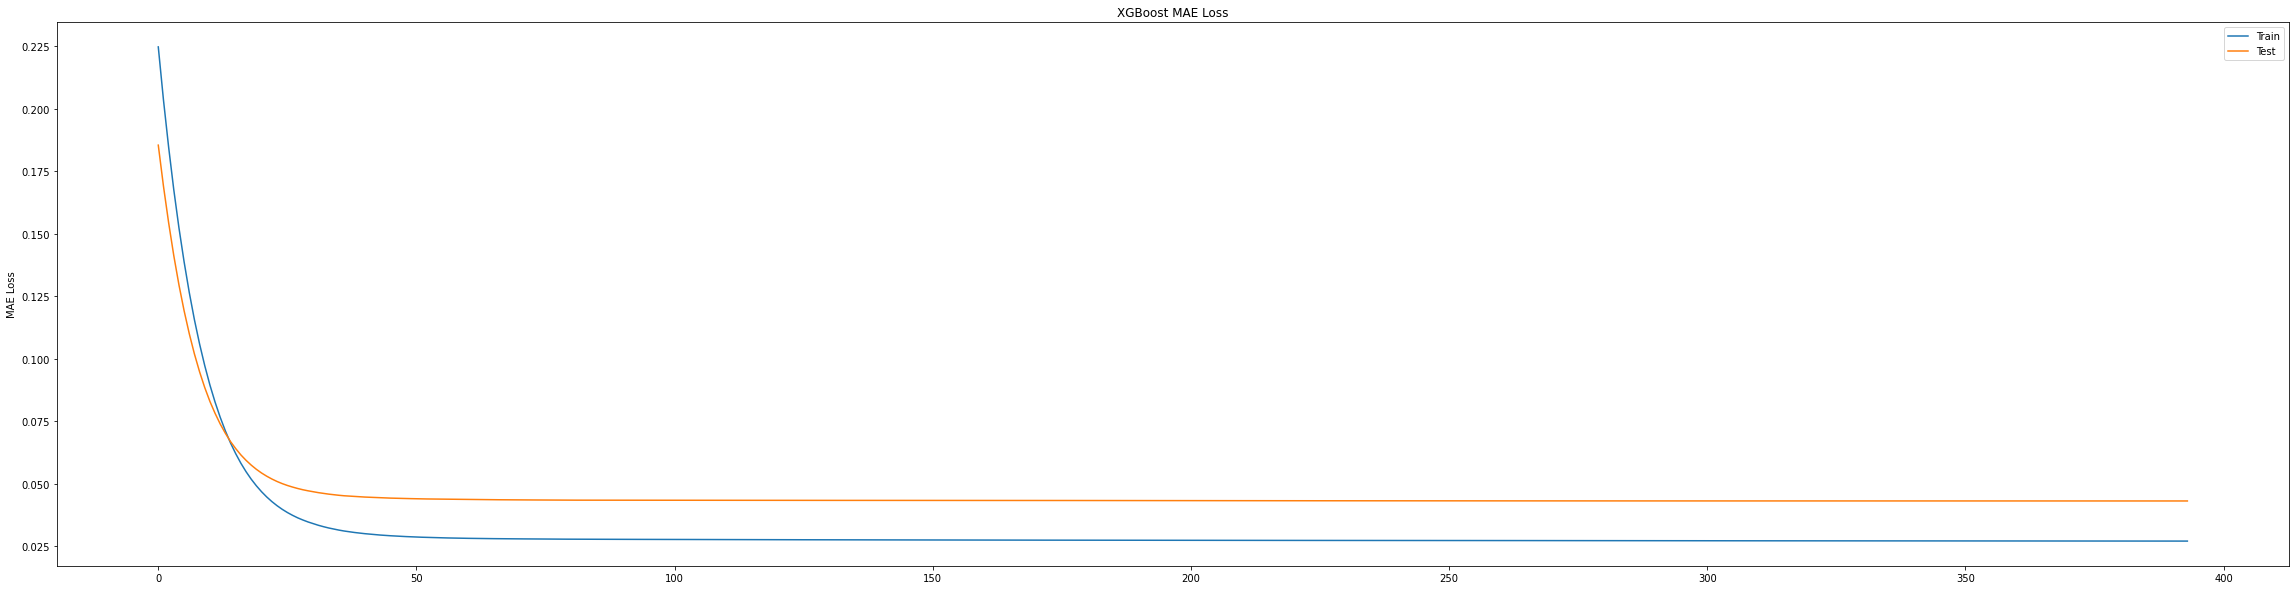

In [ ]:
plot_loss(model_y)

In [ ]:
print("Value of MAE for Y:")
round(mean_absolute_error(sy_test_Y, preds_y) * 100,2)

Value of MAE for Y:


4.31

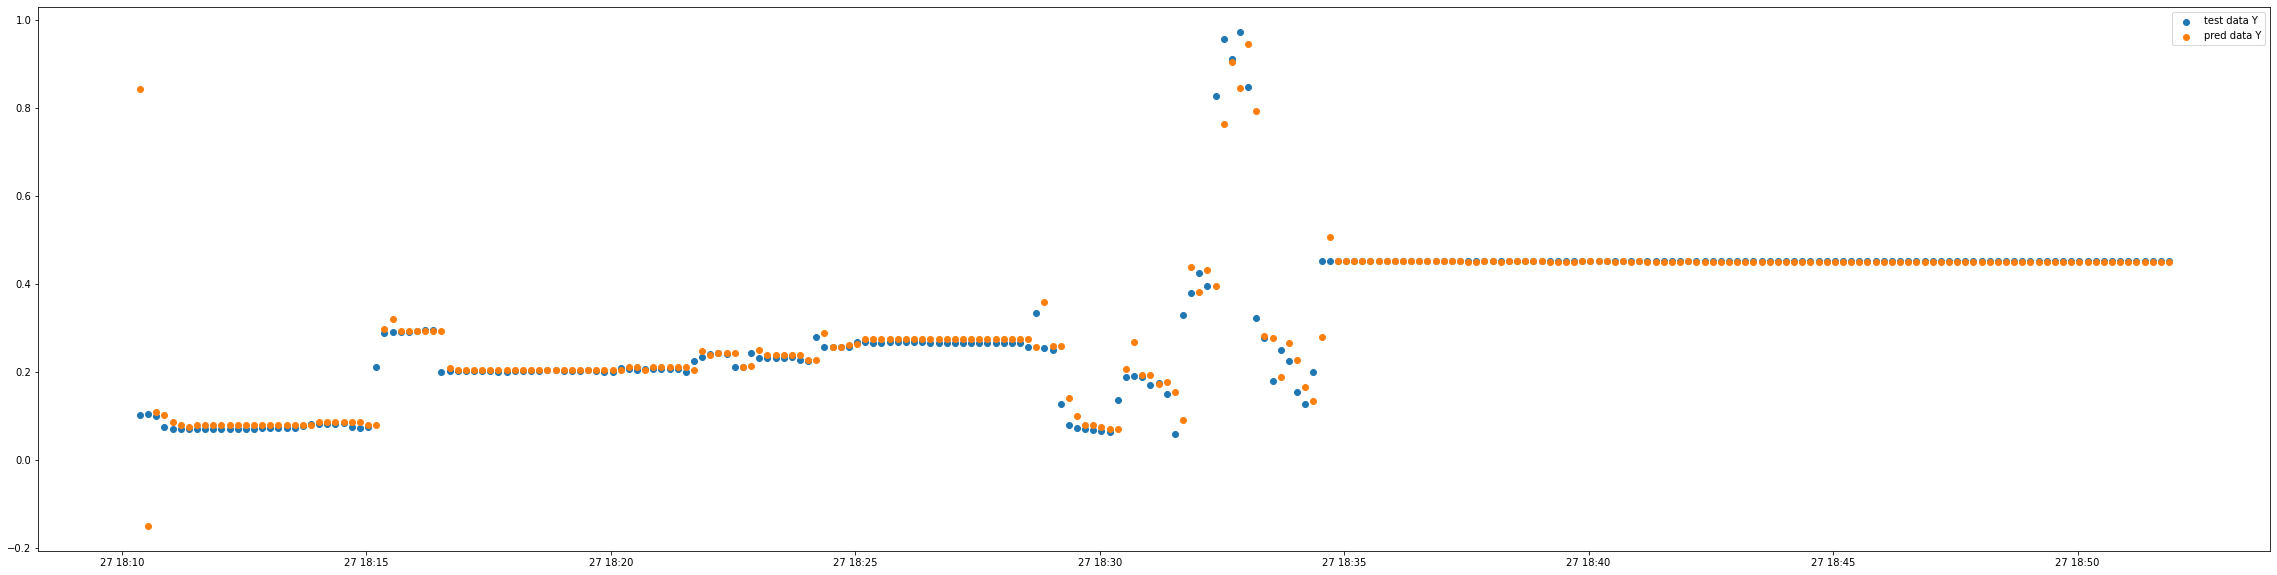

In [ ]:
plt.scatter(norm_test_data[:250]['timestamp'],sy_test_Y[:250], label = "test data Y")
plt.scatter(norm_test_data[:250]['timestamp'], np.asarray(preds_y)[:250], label = "pred data Y")

plt.legend()
plt.show()

Result for sample of size 25:
Input: [0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718], Predicted: [0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746]
MAE: 0.000574



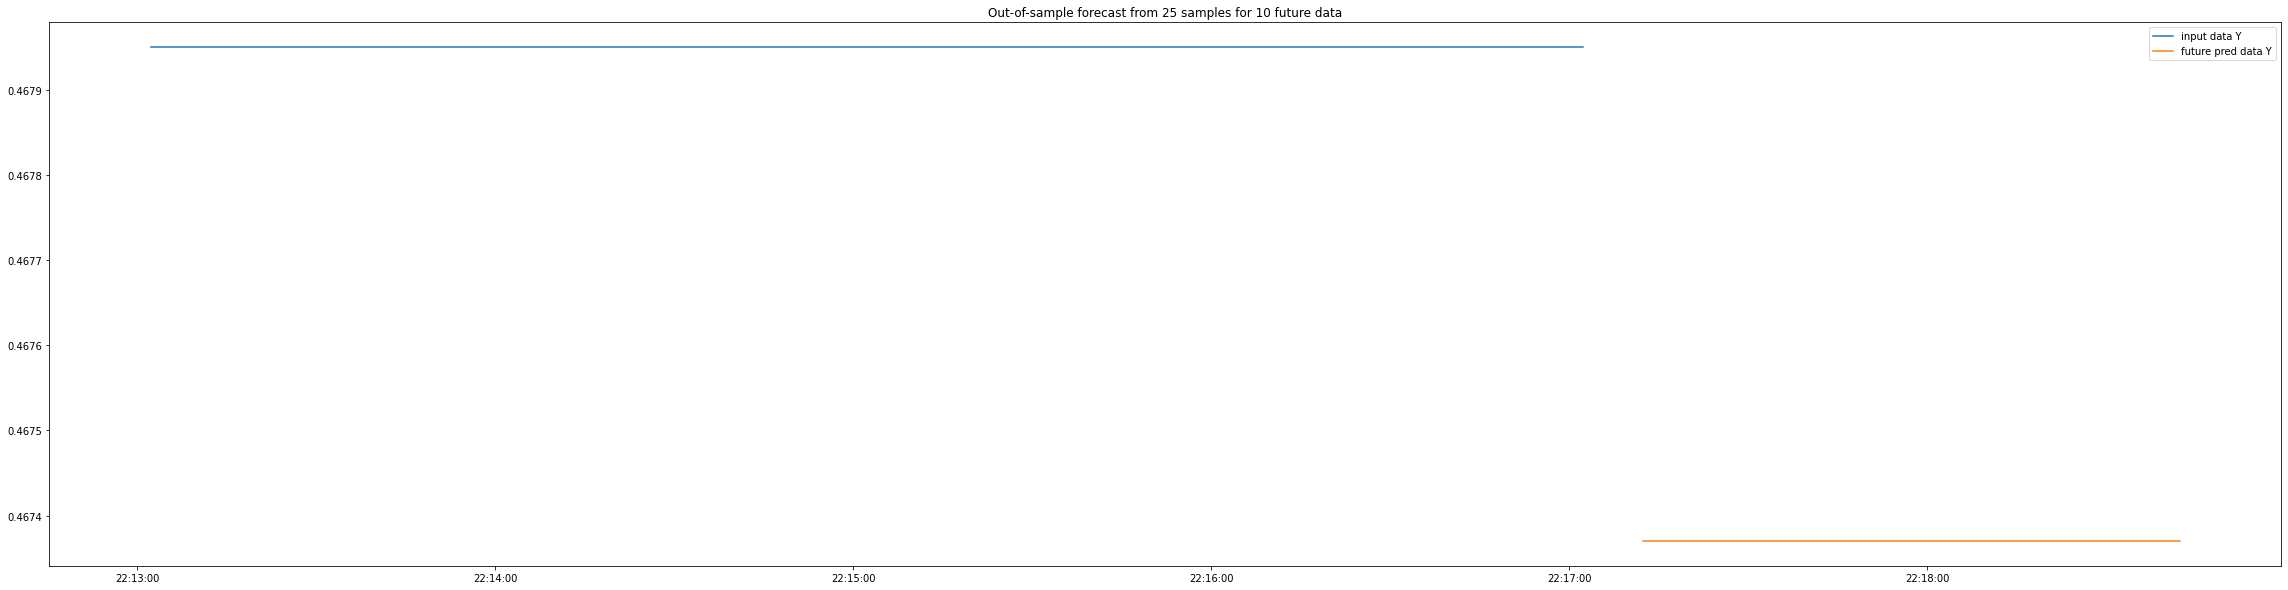

Result for sample of size 25:
Input: [0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718], Predicted: [0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746]
MAE: 0.000478



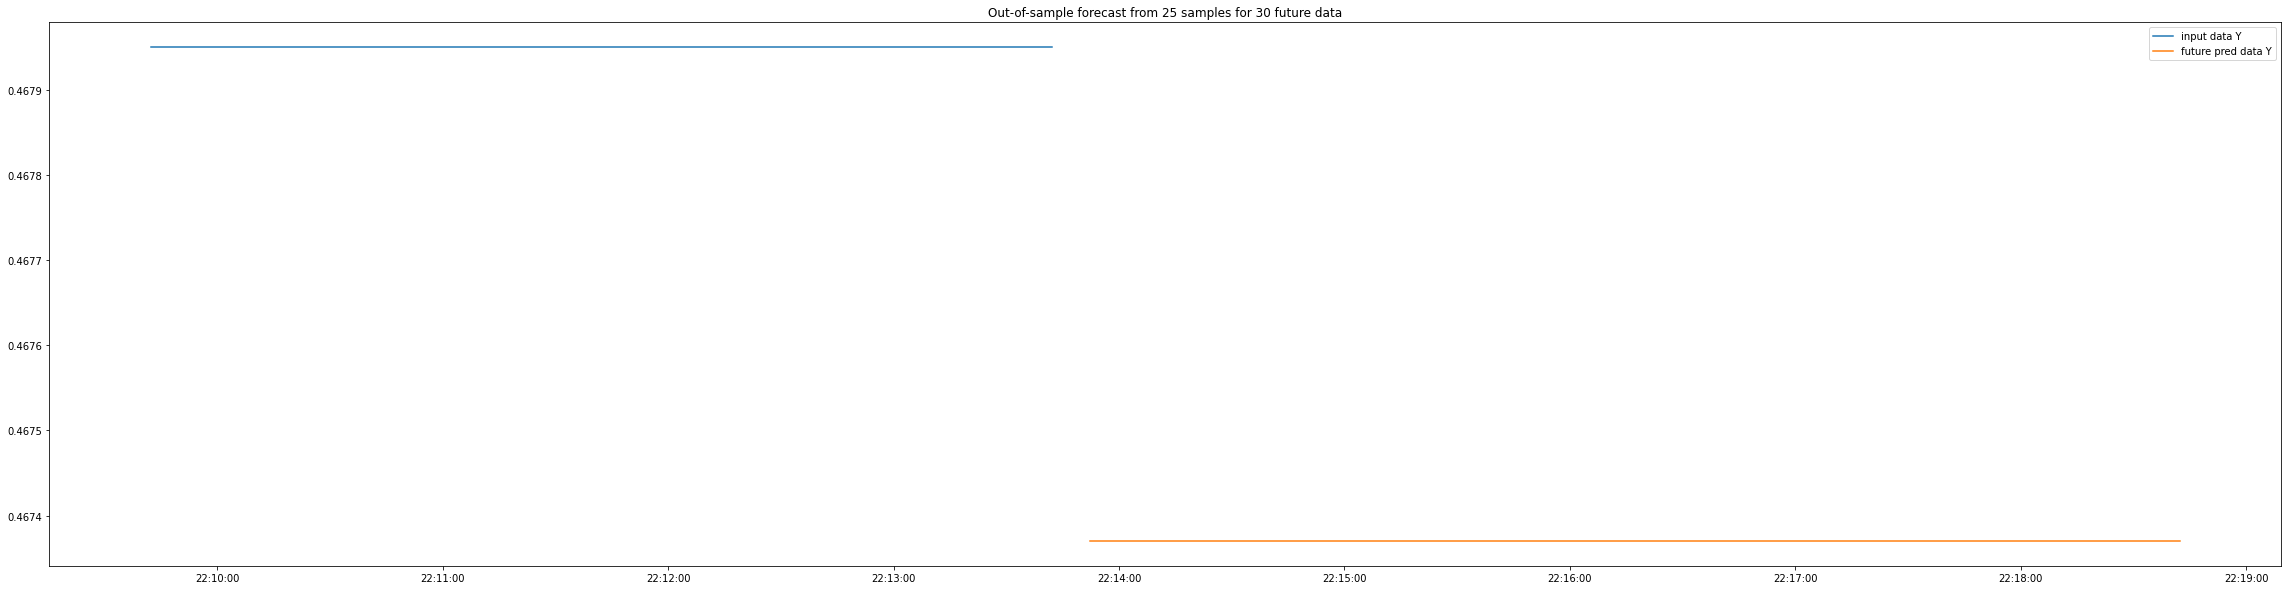

Result for sample of size 25:
Input: [0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718, 0.467948717948718], Predicted: [0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0.4673746, 0

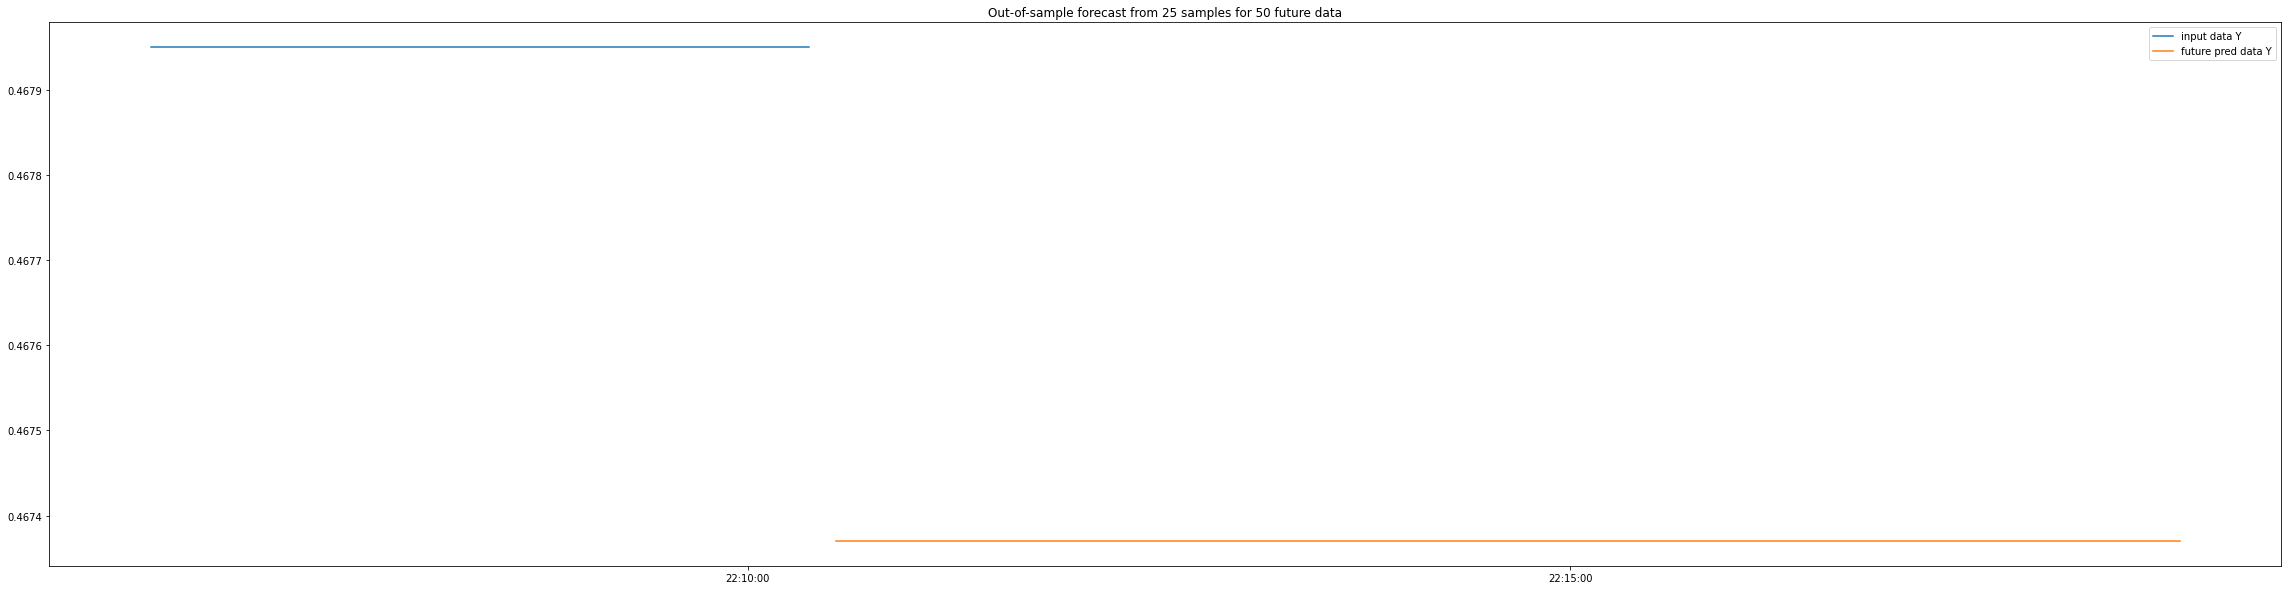

In [ ]:
#  out-of-sample forecast, predicting beyond the training dataset

data = list(norm_test_data['y'].values)
sample_size = 25
for to_pred in [10,30,50]:
  input, preds = out_of_sample_forecast(data, to_pred, sample_size)
  input = [round(v,5) for v in input]
  preds = [round(v,5) for v in preds]
  plt.plot(norm_test_data[-(to_pred+sample_size):-to_pred]['timestamp'],input, label = "input data Y")
  plt.plot(norm_test_data[-to_pred:]['timestamp'], preds, label = "future pred data Y")
  plt.title("Out-of-sample forecast from %d samples for %d future data" % (sample_size,to_pred))
  plt.gca().xaxis.set_major_formatter(myFmt) # apply the format to the desired axis
  plt.legend()
  plt.show()

# Time series **Z**

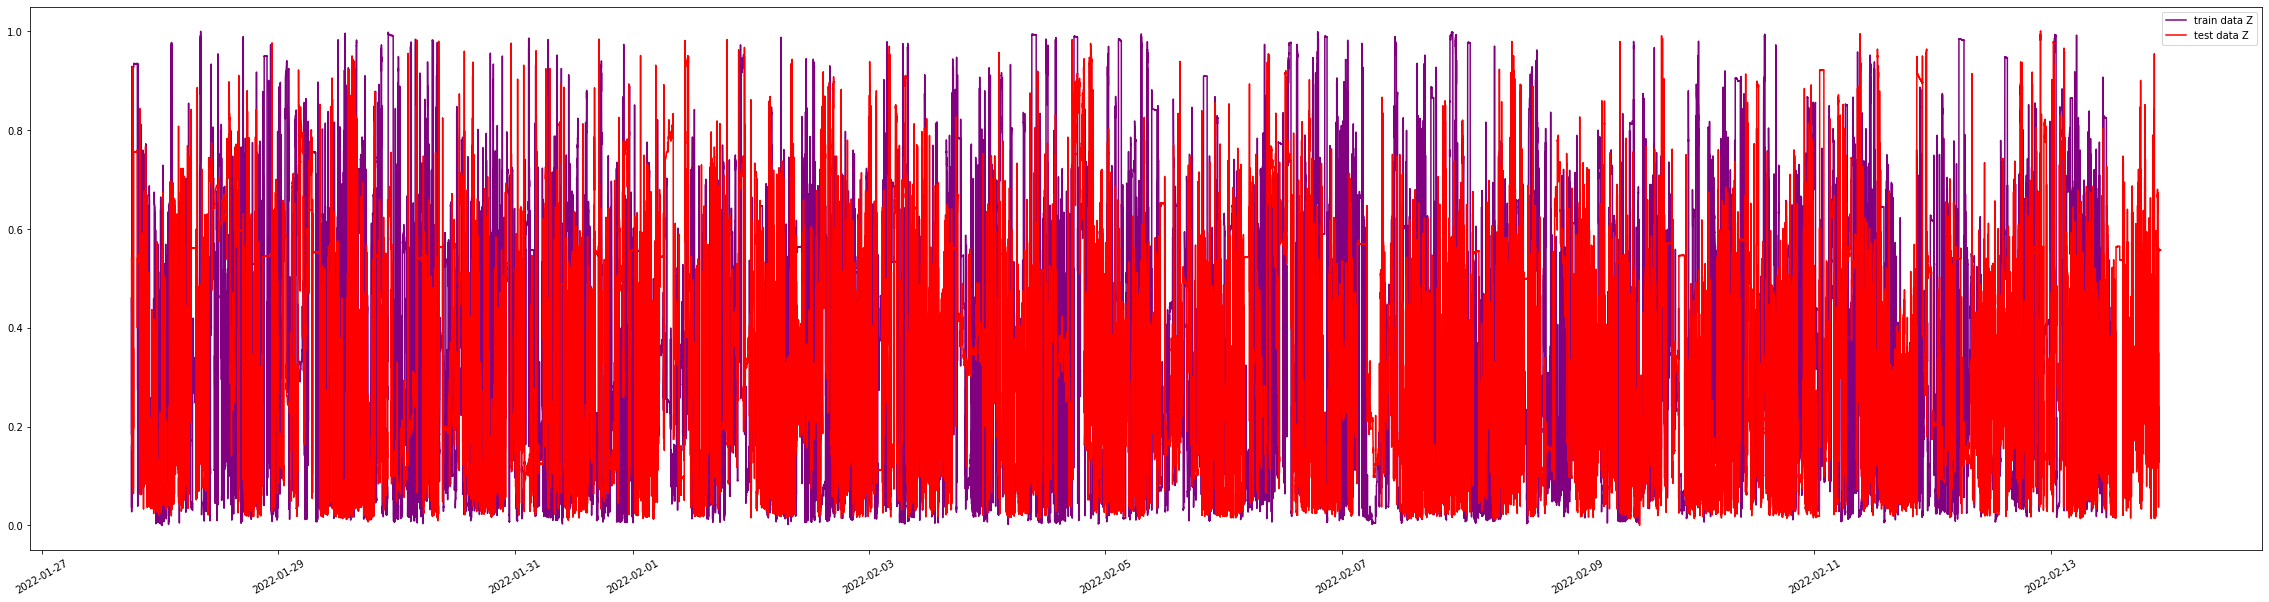

In [ ]:
plt.plot(z_train["z"], label = "train data Z", color="purple")
plt.plot(z_test["z"], label = "test data Z",color="red")
plt.xticks(rotation=30)
plt.legend()
plt.show()
# horizontal/stationary trend

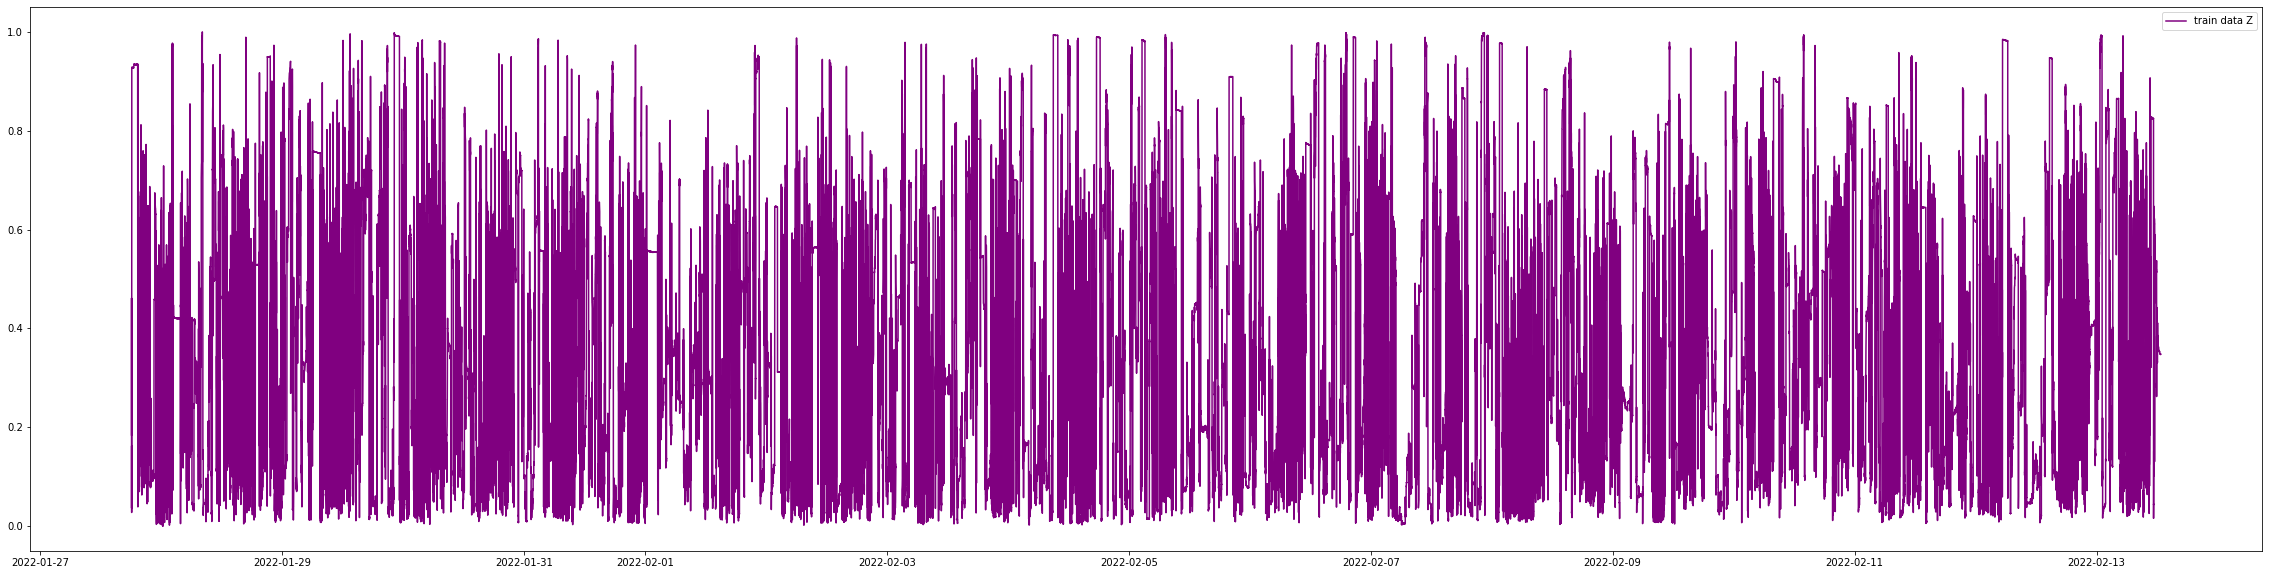

In [ ]:
plt.plot(z_train["z"], label = "train data Z", color ="purple")
plt.legend()
plt.show()

In [ ]:
z_train, z_train_out = lag_features(z_train, 'z')
z_test, z_test_out = lag_features(z_test, 'z')

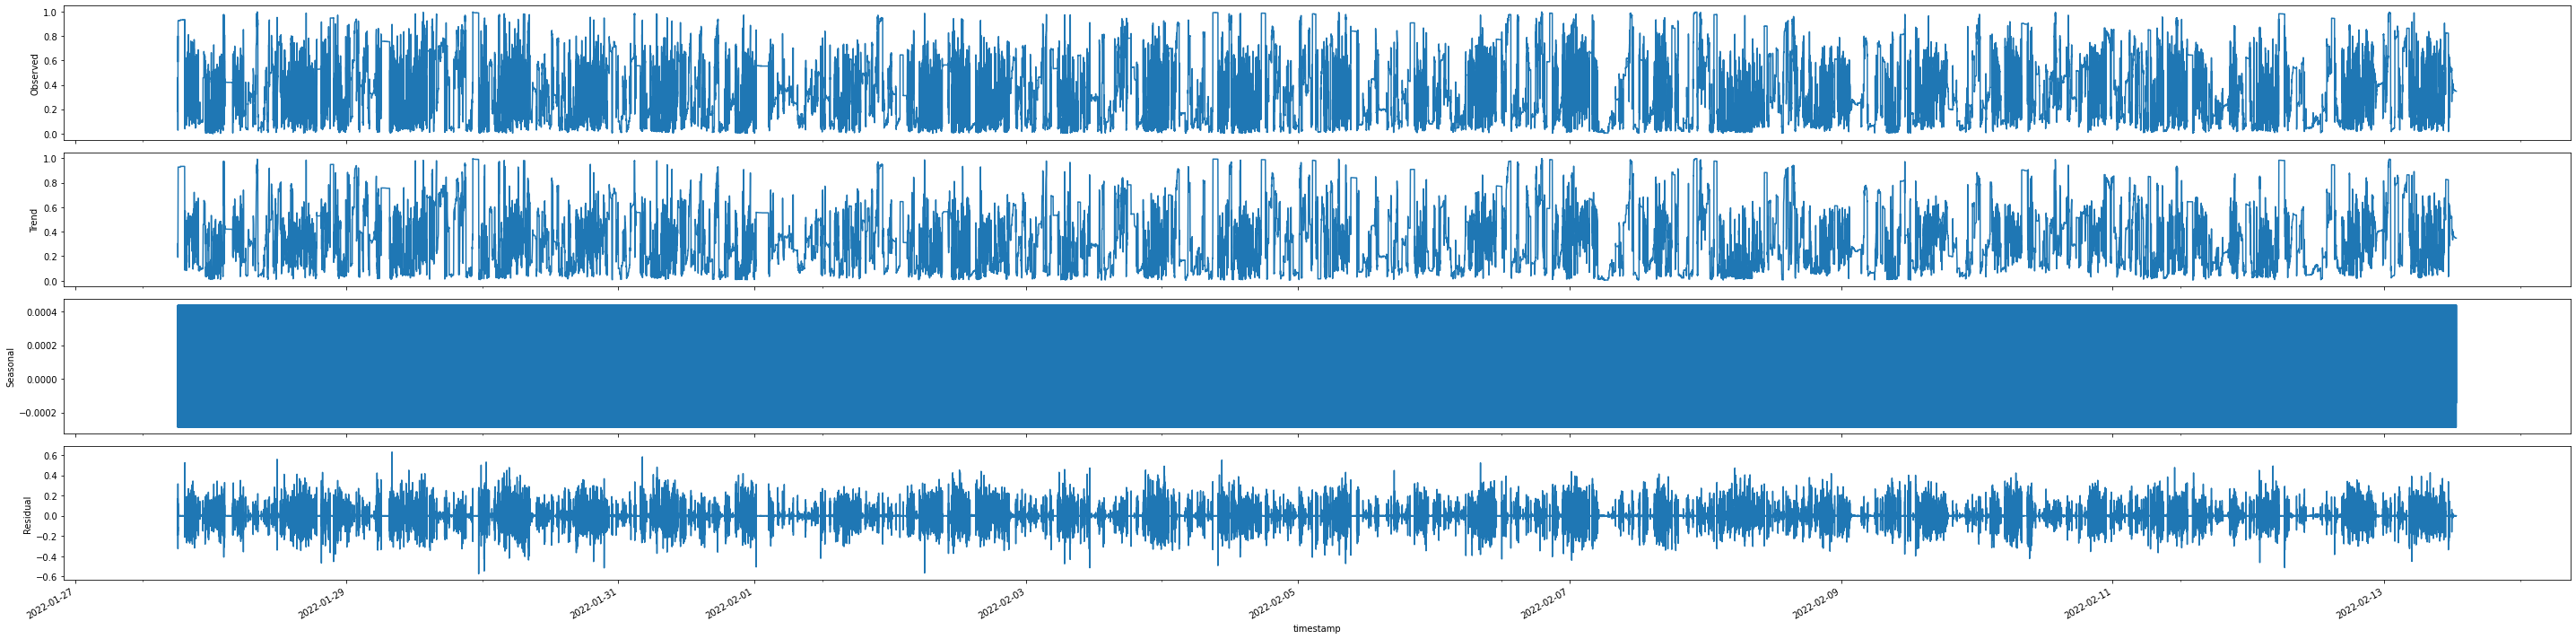

In [ ]:
mul_decomp(z_train['z'])

In [ ]:
adfuller_test(z_train['z'])
# Data is Stationary, p=0 for x, p=4.281076662753223e-30 for y

ADF Statistic: -22.433212936525287
p-value: 0.0
Critial Values:
   1%, -3.43039515048676
Critial Values:
   5%, -2.861559955875853
Critial Values:
   10%, -2.5667806218025513


In [ ]:
# train data splitting
sx_train_Z, sy_train_Z = z_train.drop(['z'], axis=1), z_train['z']
sx_test_Z, sy_test_Z = z_test.drop(['z'], axis=1), z_test['z']

In [ ]:
# model
model_z = xgb.XGBRegressor(n_estimators=1000)
model_z.fit(sx_train_Z, sy_train_Z,
        eval_set=[(sx_train_Z, sy_train_Z), (sx_test_Z, sy_test_Z)], eval_metric="mae",
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True) 

[18:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.244107	validation_1-mae:0.228899
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.221971	validation_1-mae:0.207632
[2]	validation_0-mae:0.202354	validation_1-mae:0.189196
[3]	validation_0-mae:0.184749	validation_1-mae:0.172617
[4]	validation_0-mae:0.168894	validation_1-mae:0.157513
[5]	validation_0-mae:0.154785	validation_1-mae:0.144355
[6]	validation_0-mae:0.142095	validation_1-mae:0.132546
[7]	validation_0-mae:0.130861	validation_1-mae:0.122004
[8]	validation_0-mae:0.120715	validation_1-mae:0.112796
[9]	validation_0-mae:0.111774	validation_1-mae:0.104673
[10]	validation_0-mae:0.10373	validation_1-mae:0.097405
[11]	validation_0-mae:0.09657	validation_1-mae:0.090902
[12]	validation_0-mae:0.090175	validation_1-

XGBRegressor(n_estimators=1000)

In [ ]:
preds_z = pd.DataFrame(model_z.predict(sx_test_Z))

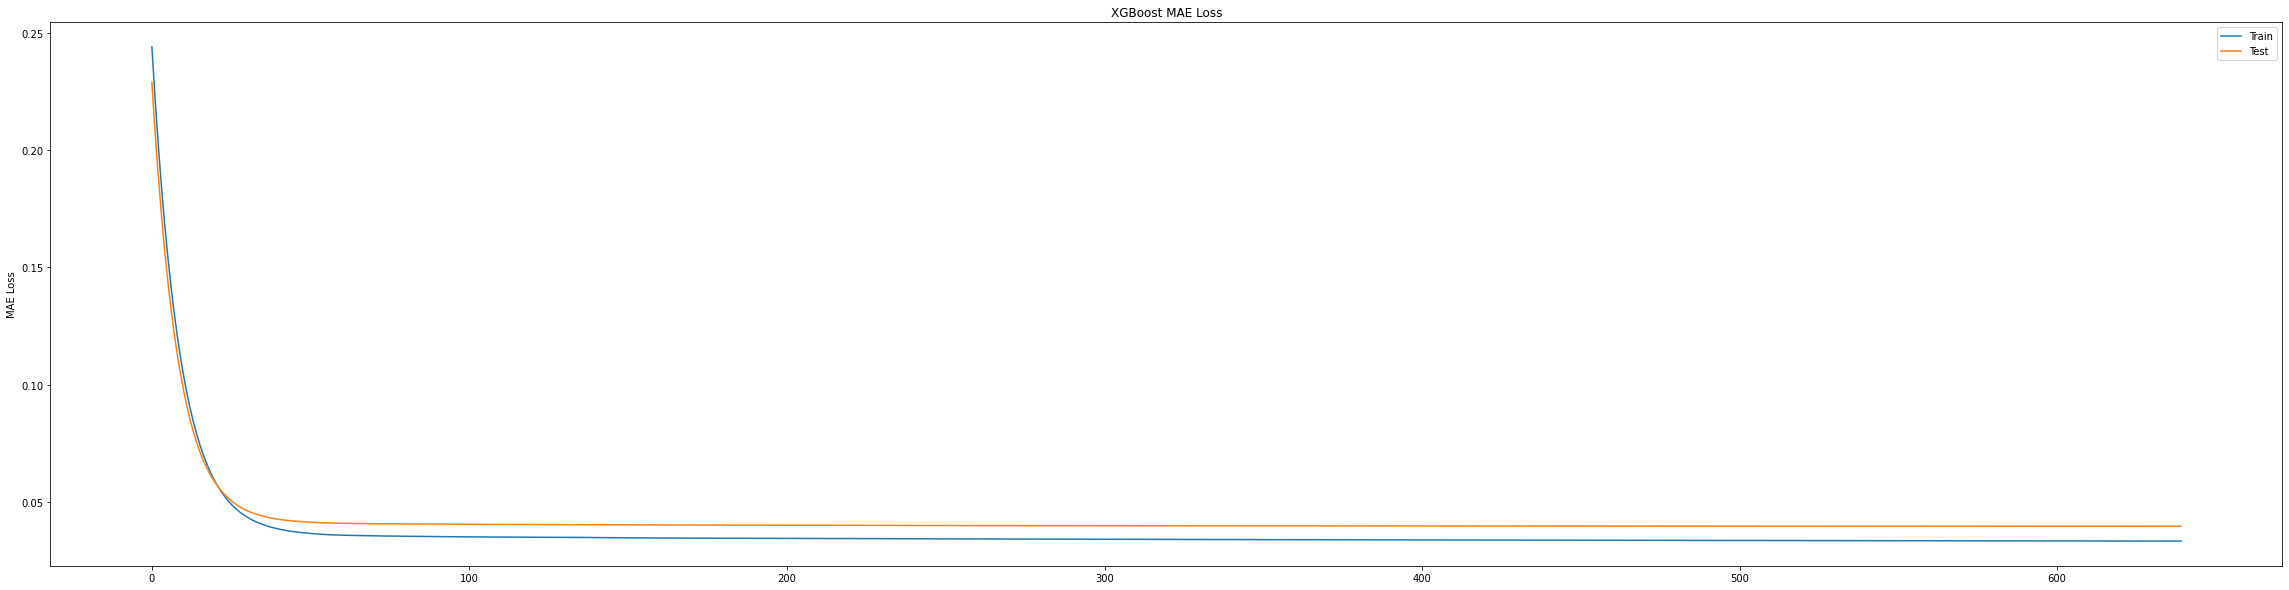

In [ ]:
plot_loss(model_z)

In [ ]:
print("Value of MAE for Z:")
round(mean_absolute_error(sy_test_Z, preds_z) * 100,2)

Value of MAE for Z:


3.96

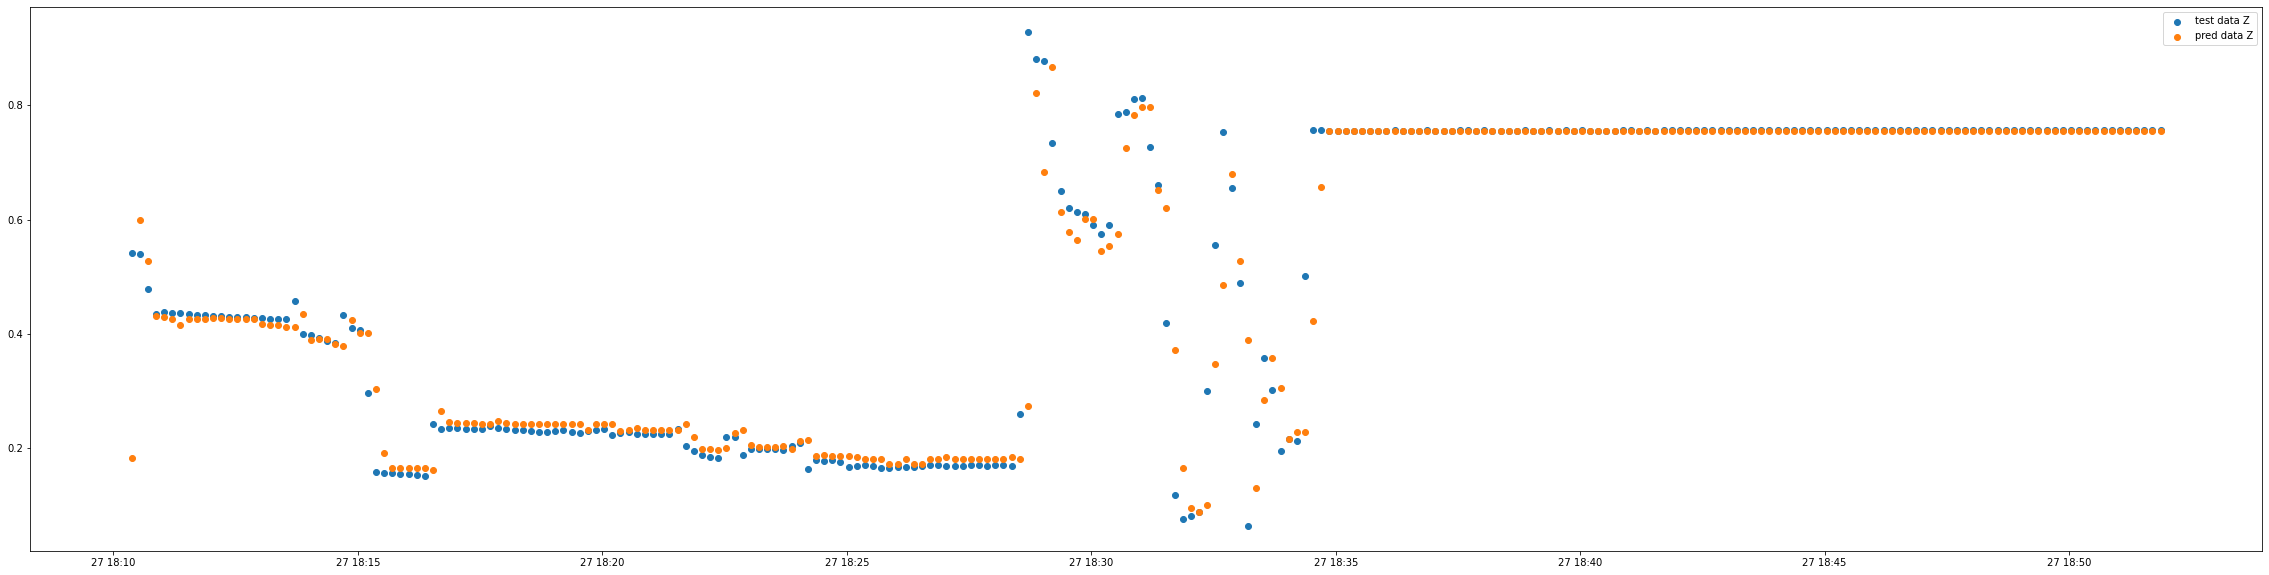

In [ ]:
plt.scatter(norm_test_data[:250]['timestamp'],sy_test_Z[:250], label = "test data Z")
plt.scatter(norm_test_data[:250]['timestamp'], np.asarray(preds_z)[:250], label = "pred data Z")

plt.legend()
plt.show()

Result for sample of size 25:
Input: [0.557369179068651, 0.556889102256361, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.556889102256361, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651], Predicted: [0.5543951, 0.54881054, 0.5441687, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797]
MAE: 0.009617



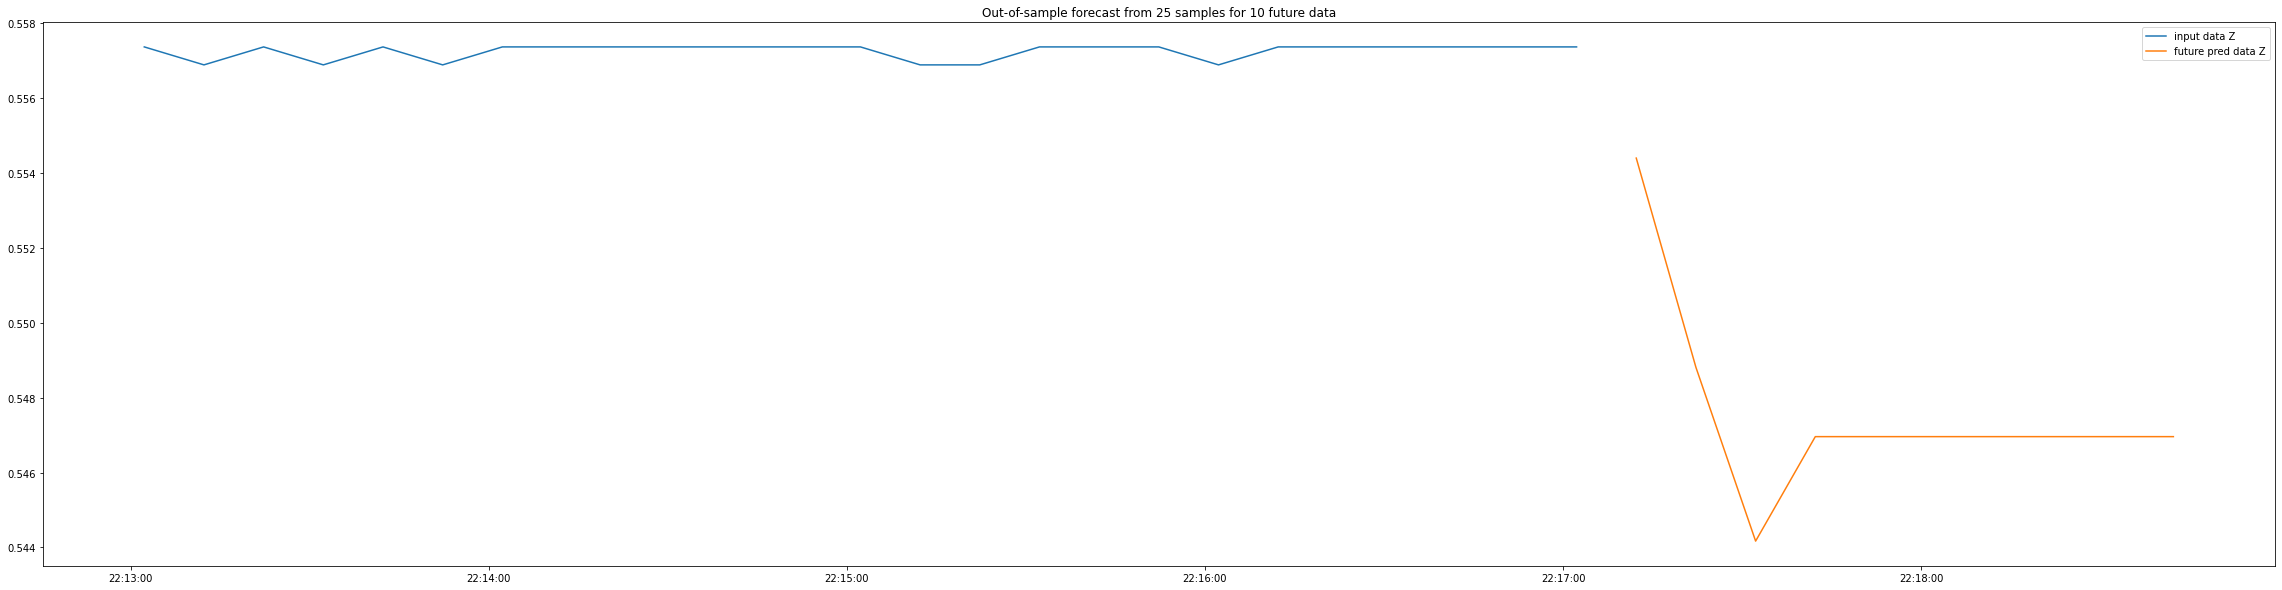

Result for sample of size 25:
Input: [0.557369179068651, 0.556889102256361, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.556889102256361, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651], Predicted: [0.5543951, 0.54881054, 0.5441687, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.5428901, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.5428901, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797]
MAE: 0.009037



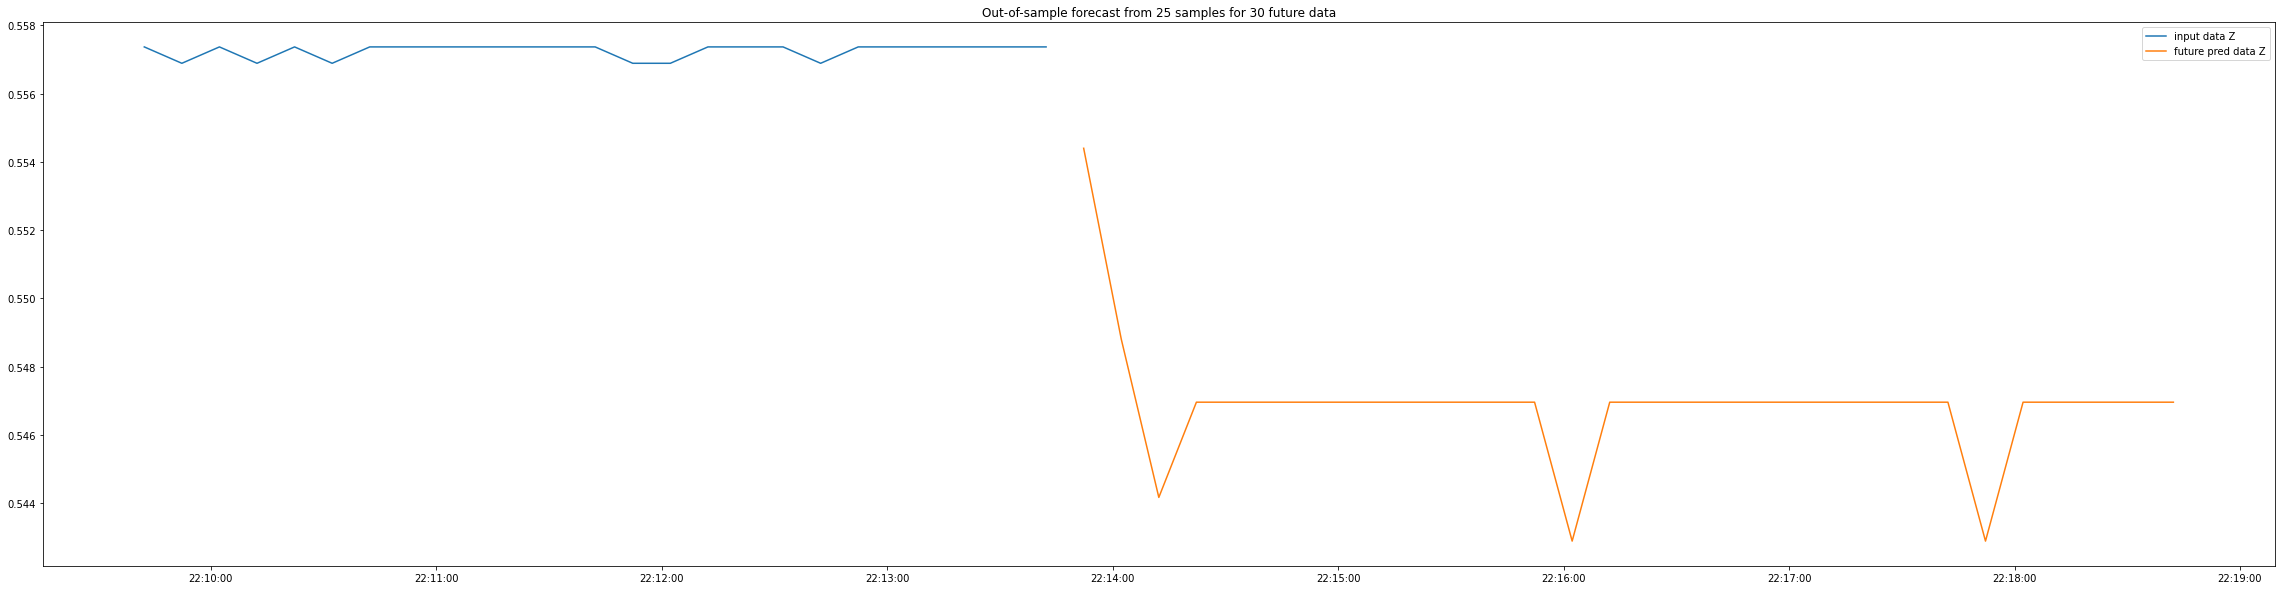

Result for sample of size 25:
Input: [0.557369179068651, 0.556889102256361, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.556889102256361, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.556889102256361, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651, 0.557369179068651], Predicted: [0.5543951, 0.54881054, 0.5441687, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.5428901, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.5428901, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.54695797, 0.5428901, 0.54695797, 0.54695797, 0.54695797, 0.54695797,

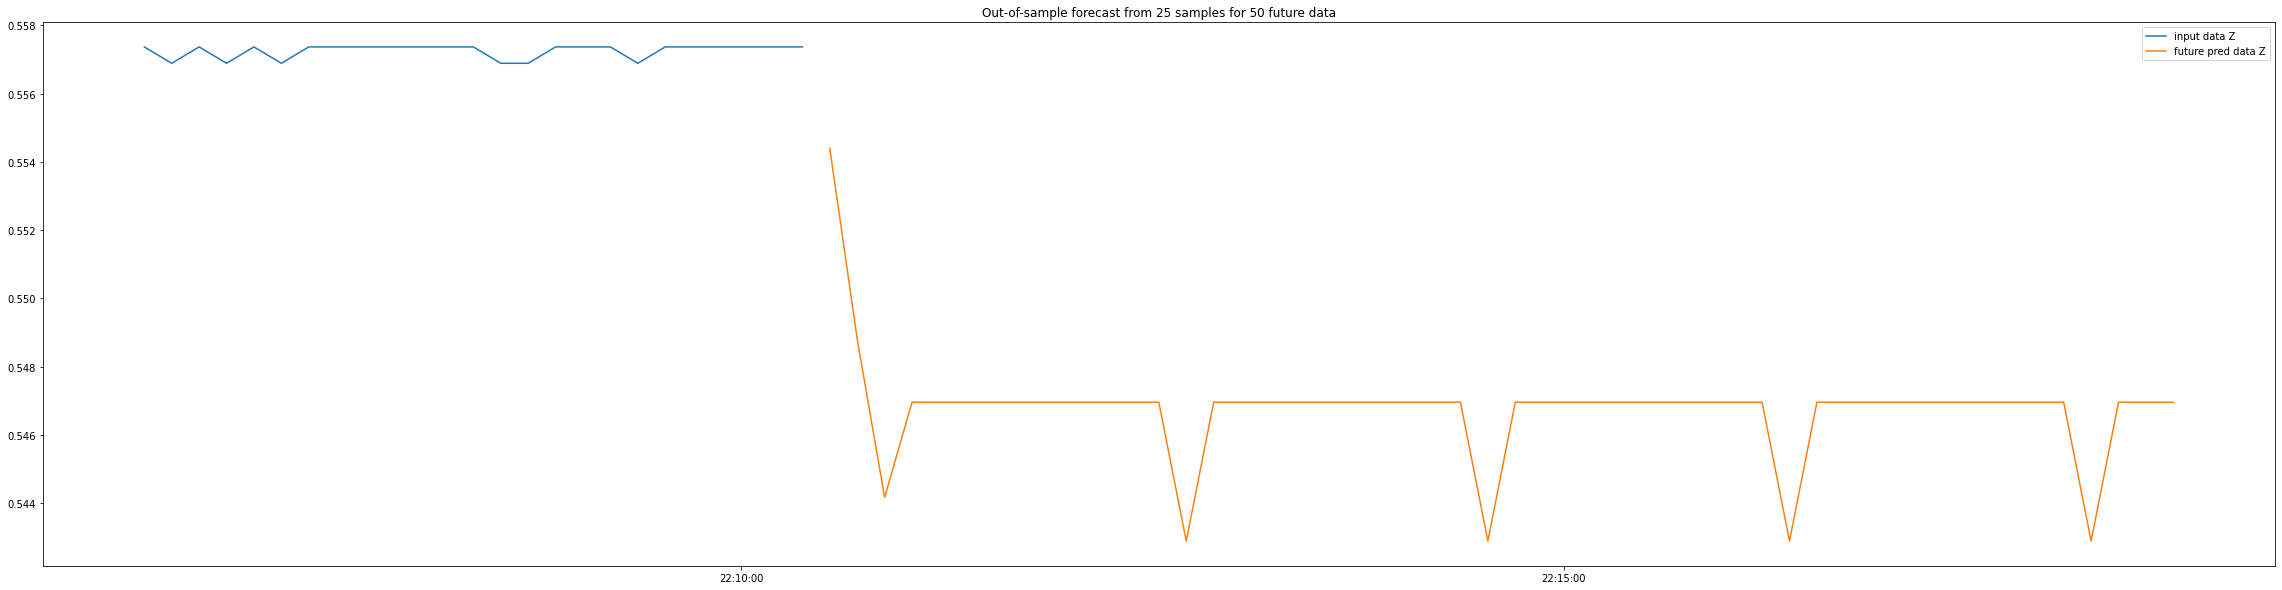

In [ ]:
#  out-of-sample forecast, predicting beyond the training dataset

data = list(norm_test_data['z'].values)
sample_size = 25
for to_pred in [10,30,50]:
  input, preds = out_of_sample_forecast(data, to_pred, sample_size)
  input = [round(v,5) for v in input]
  preds = [round(v,5) for v in preds]
  plt.plot(norm_test_data[-(to_pred+sample_size):-to_pred]['timestamp'],input, label = "input data Z")
  plt.plot(norm_test_data[-to_pred:]['timestamp'], preds, label = "future pred data Z")
  plt.title("Out-of-sample forecast from %d samples for %d future data" % (sample_size,to_pred))
  plt.gca().xaxis.set_major_formatter(myFmt) # apply the format to the desired axis
  plt.legend()
  plt.show()

# How do the **window_size** and the **window_shift** affect the result for time series Z?

In [ ]:
def model_experiments(train_data, test_data):
  # train data splitting
  z_train = train_data
  z_test = test_data
  sx_train_Z, sy_train_Z = z_train.drop(['x'], axis=1), z_train['x']
  sx_test_Z, sy_test_Z = z_test.drop(['x'], axis=1), z_test['x']

  # model

  model_z = xgb.XGBRegressor(n_estimators=1000)
  model_z.fit(sx_train_Z, sy_train_Z,
          eval_set=[(sx_train_Z, sy_train_Z), (sx_test_Z, sy_test_Z)], eval_metric="mae",
          early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
          verbose=True) 
  preds_z = pd.DataFrame(model_z.predict(sx_test_Z))

  print("Value of MAE for X:")
  print(round(mean_absolute_error(sy_test_Z, preds_z) * 100,2))
  print("\n")
  rcParams["figure.figsize"] = 40,5
  myFmt = DateFormatter("%H:%M:%S")
  plt.scatter(norm_test_data[:250]['timestamp'],sy_test_Z[:250], label = "test data X")
  plt.scatter(norm_test_data[:250]['timestamp'], np.asarray(preds_z)[:250], label = "pred data X")
  #plt.gca.xaxis.set_major_formatter(myFmt) # apply the format to the desired axis
  plt.legend()
  plt.show()
  return model_z

[18:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.189523	validation_1-mae:0.232784
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.17382	validation_1-mae:0.214176
[2]	validation_0-mae:0.159849	validation_1-mae:0.197688
[3]	validation_0-mae:0.147384	validation_1-mae:0.183199
[4]	validation_0-mae:0.136259	validation_1-mae:0.170181
[5]	validation_0-mae:0.12625	validation_1-mae:0.158294
[6]	validation_0-mae:0.117219	validation_1-mae:0.147487
[7]	validation_0-mae:0.109158	validation_1-mae:0.137969
[8]	validation_0-mae:0.101975	validation_1-mae:0.129417
[9]	validation_0-mae:0.095502	validation_1-mae:0.121827
[10]	validation_0-mae:0.089733	validation_1-mae:0.11497
[11]	validation_0-mae:0.084538	validation_1-mae:0.1088
[12]	validation_0-mae:0.079909	validation_1-mae

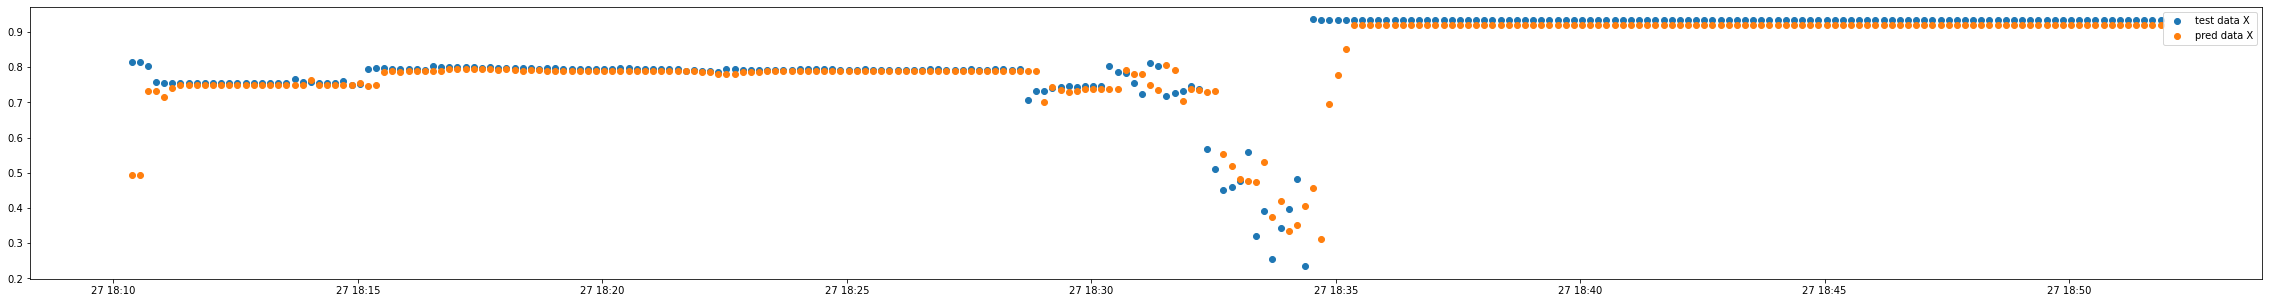

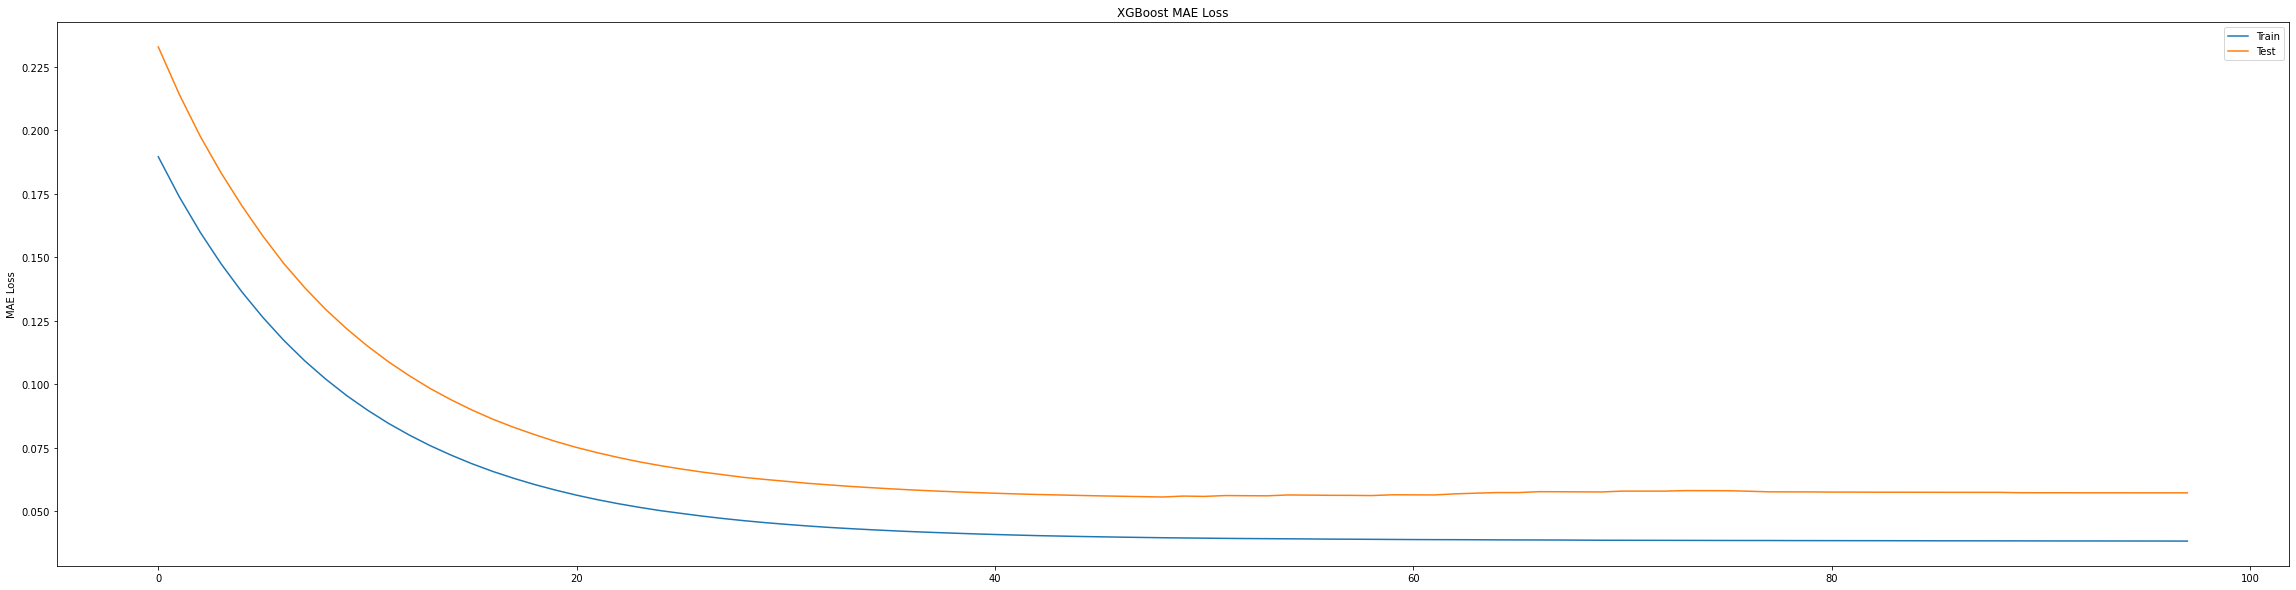

In [ ]:
# window_size = 4, shift = 2
z_train, z_train_out = lag_features(x_train, 'x', shift = 2, window_size=4)
z_test, z_test_out = lag_features(x_test, 'x',shift = 2,  window_size=4)
model = model_experiments(z_train, z_test)
plot_loss(model)

[18:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.190755	validation_1-mae:0.234185
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.176328	validation_1-mae:0.216983
[2]	validation_0-mae:0.163427	validation_1-mae:0.201656
[3]	validation_0-mae:0.151815	validation_1-mae:0.187724
[4]	validation_0-mae:0.141492	validation_1-mae:0.175431
[5]	validation_0-mae:0.132312	validation_1-mae:0.164675
[6]	validation_0-mae:0.124031	validation_1-mae:0.154794
[7]	validation_0-mae:0.116516	validation_1-mae:0.14588
[8]	validation_0-mae:0.109869	validation_1-mae:0.137999
[9]	validation_0-mae:0.103941	validation_1-mae:0.130799
[10]	validation_0-mae:0.09857	validation_1-mae:0.124426
[11]	validation_0-mae:0.093793	validation_1-mae:0.118811
[12]	validation_0-mae:0.089534	validation_1-

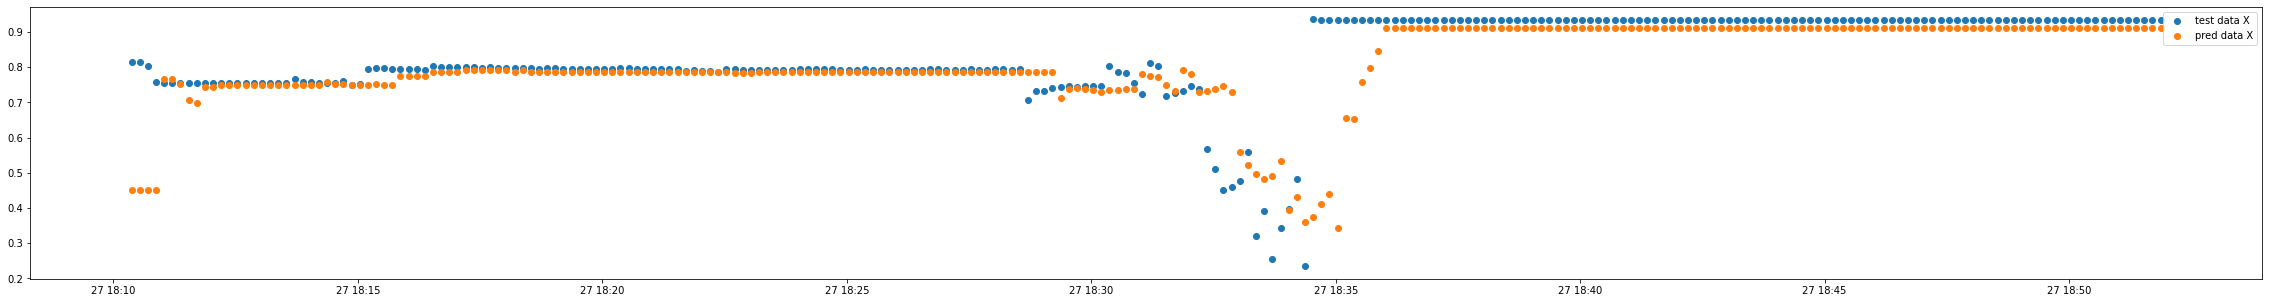

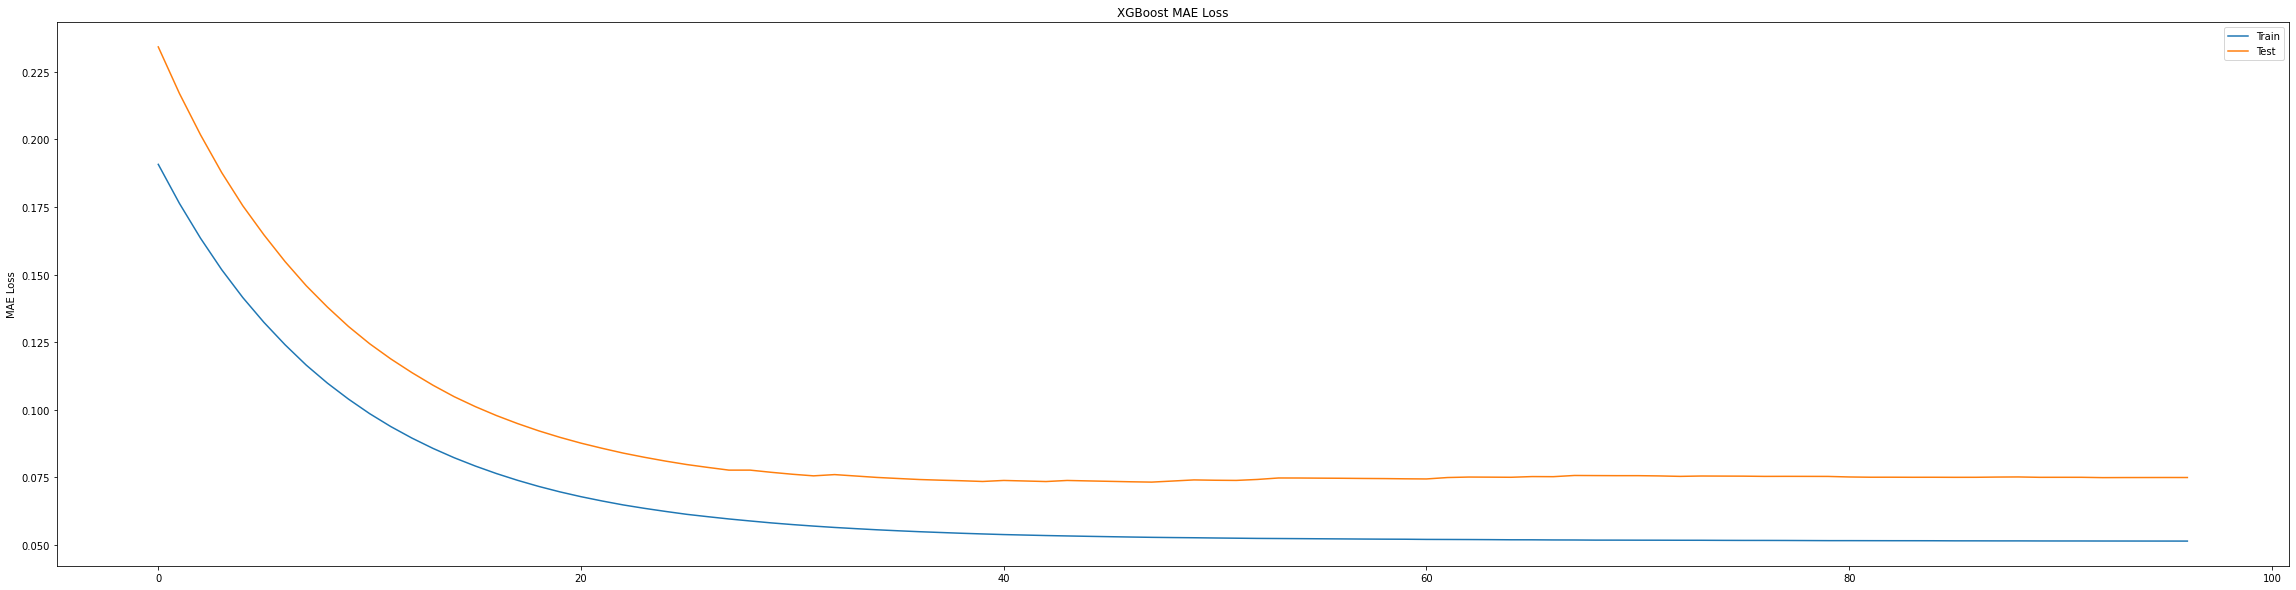

In [ ]:
# window_size = 6, shift = 4
z_train, z_train_out = lag_features(x_train, 'x', shift = 4, window_size=6)
z_test, z_test_out = lag_features(x_test, 'x',shift = 4,  window_size=6)
model = model_experiments(z_train, z_test)
plot_loss(model)

[18:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.18953	validation_1-mae:0.232779
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.173862	validation_1-mae:0.214131
[2]	validation_0-mae:0.159893	validation_1-mae:0.197491
[3]	validation_0-mae:0.147447	validation_1-mae:0.18296
[4]	validation_0-mae:0.136253	validation_1-mae:0.1697
[5]	validation_0-mae:0.126274	validation_1-mae:0.158029
[6]	validation_0-mae:0.11733	validation_1-mae:0.147438
[7]	validation_0-mae:0.109332	validation_1-mae:0.137837
[8]	validation_0-mae:0.102142	validation_1-mae:0.129067
[9]	validation_0-mae:0.095675	validation_1-mae:0.121513
[10]	validation_0-mae:0.089919	validation_1-mae:0.114529
[11]	validation_0-mae:0.08475	validation_1-mae:0.10834
[12]	validation_0-mae:0.080056	validation_1-mae:0

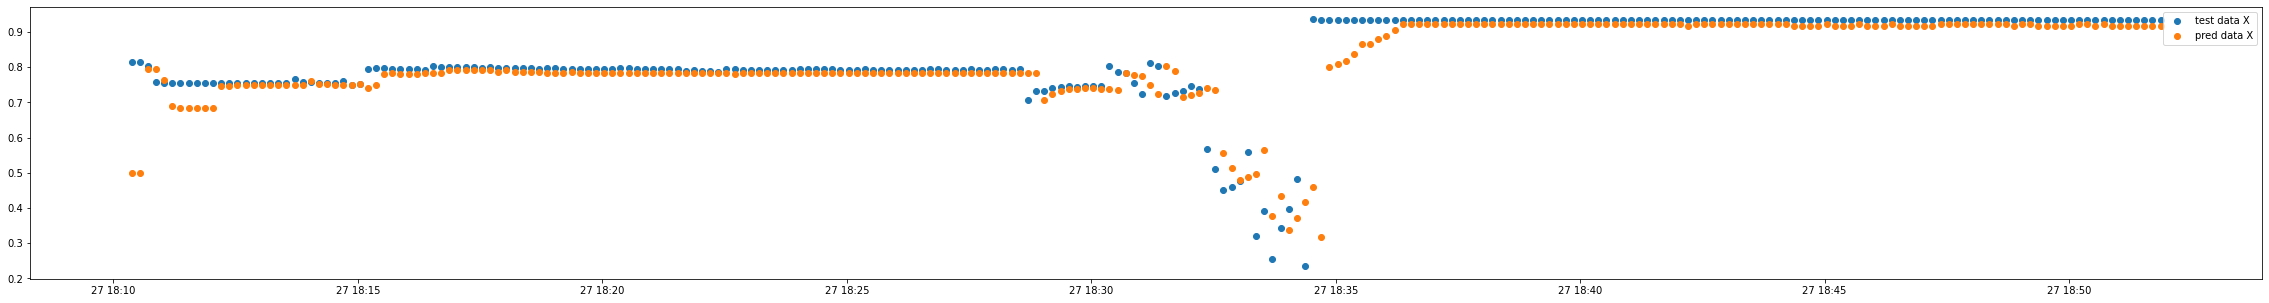

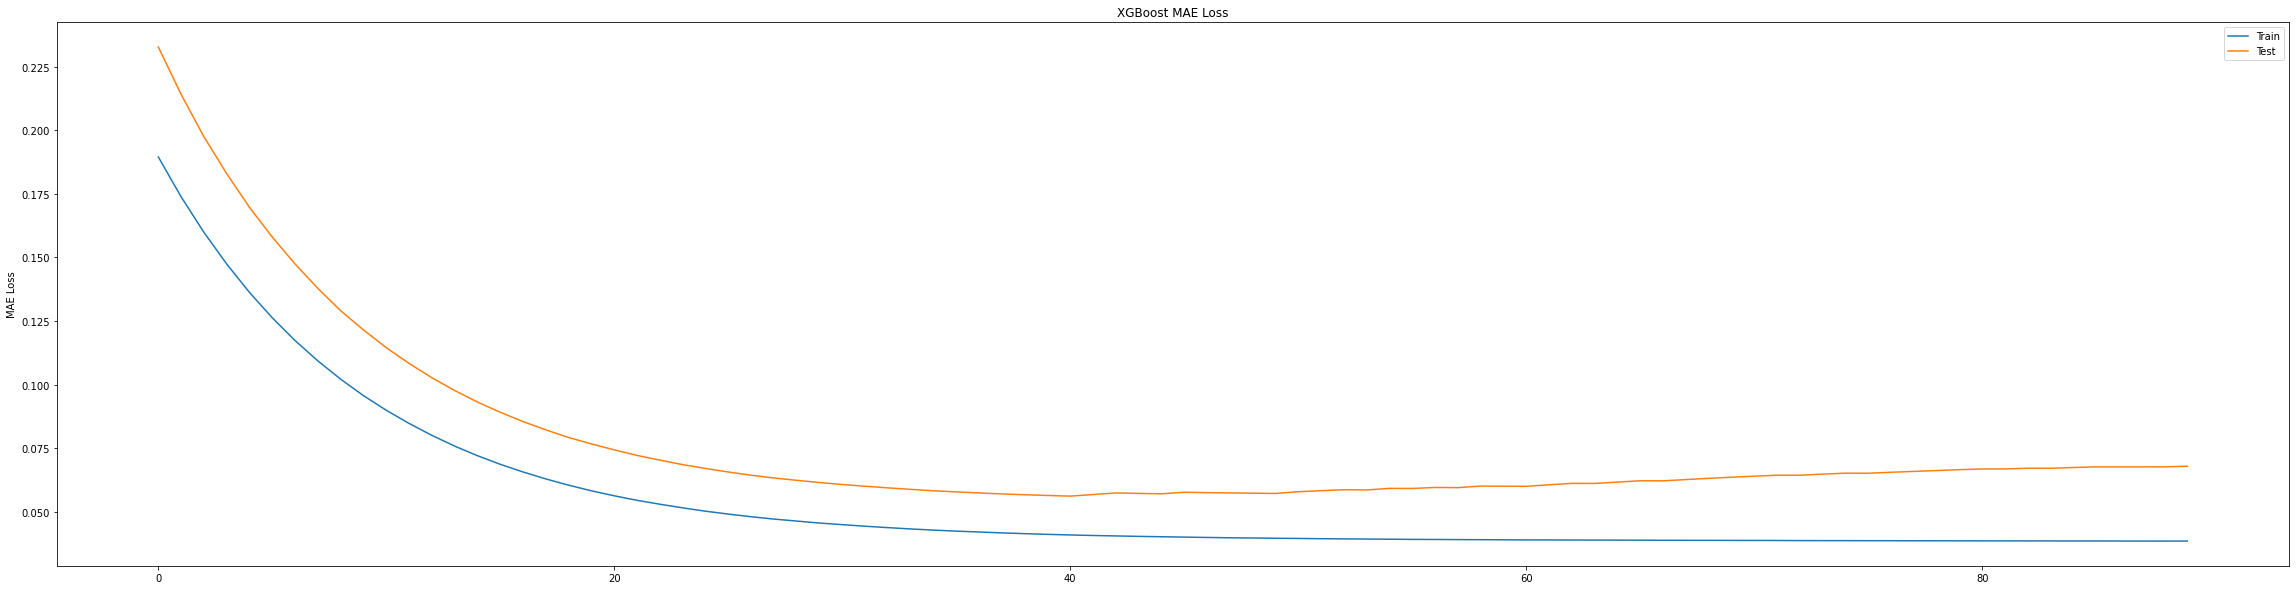

In [ ]:
# window_size = 10, shift = 2
z_train, z_train_out = lag_features(x_train, 'x', shift = 2, window_size=10)
z_test, z_test_out = lag_features(x_test, 'x',shift = 2,  window_size=10)
model = model_experiments(z_train, z_test)
plot_loss(model)

[18:34:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.190788	validation_1-mae:0.234206
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.176365	validation_1-mae:0.216918
[2]	validation_0-mae:0.163443	validation_1-mae:0.201649
[3]	validation_0-mae:0.151928	validation_1-mae:0.187734
[4]	validation_0-mae:0.141497	validation_1-mae:0.175393
[5]	validation_0-mae:0.132239	validation_1-mae:0.164404
[6]	validation_0-mae:0.123976	validation_1-mae:0.154463
[7]	validation_0-mae:0.116515	validation_1-mae:0.145702
[8]	validation_0-mae:0.109803	validation_1-mae:0.137758
[9]	validation_0-mae:0.103882	validation_1-mae:0.130591
[10]	validation_0-mae:0.098566	validation_1-mae:0.12416
[11]	validation_0-mae:0.093813	validation_1-mae:0.118366
[12]	validation_0-mae:0.089523	validation_1

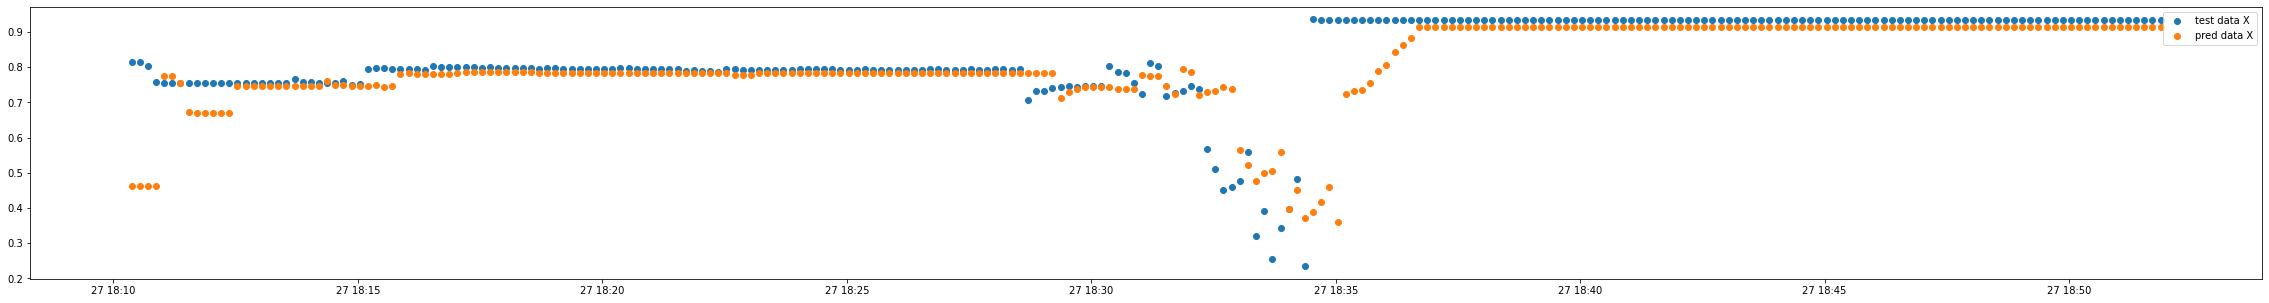

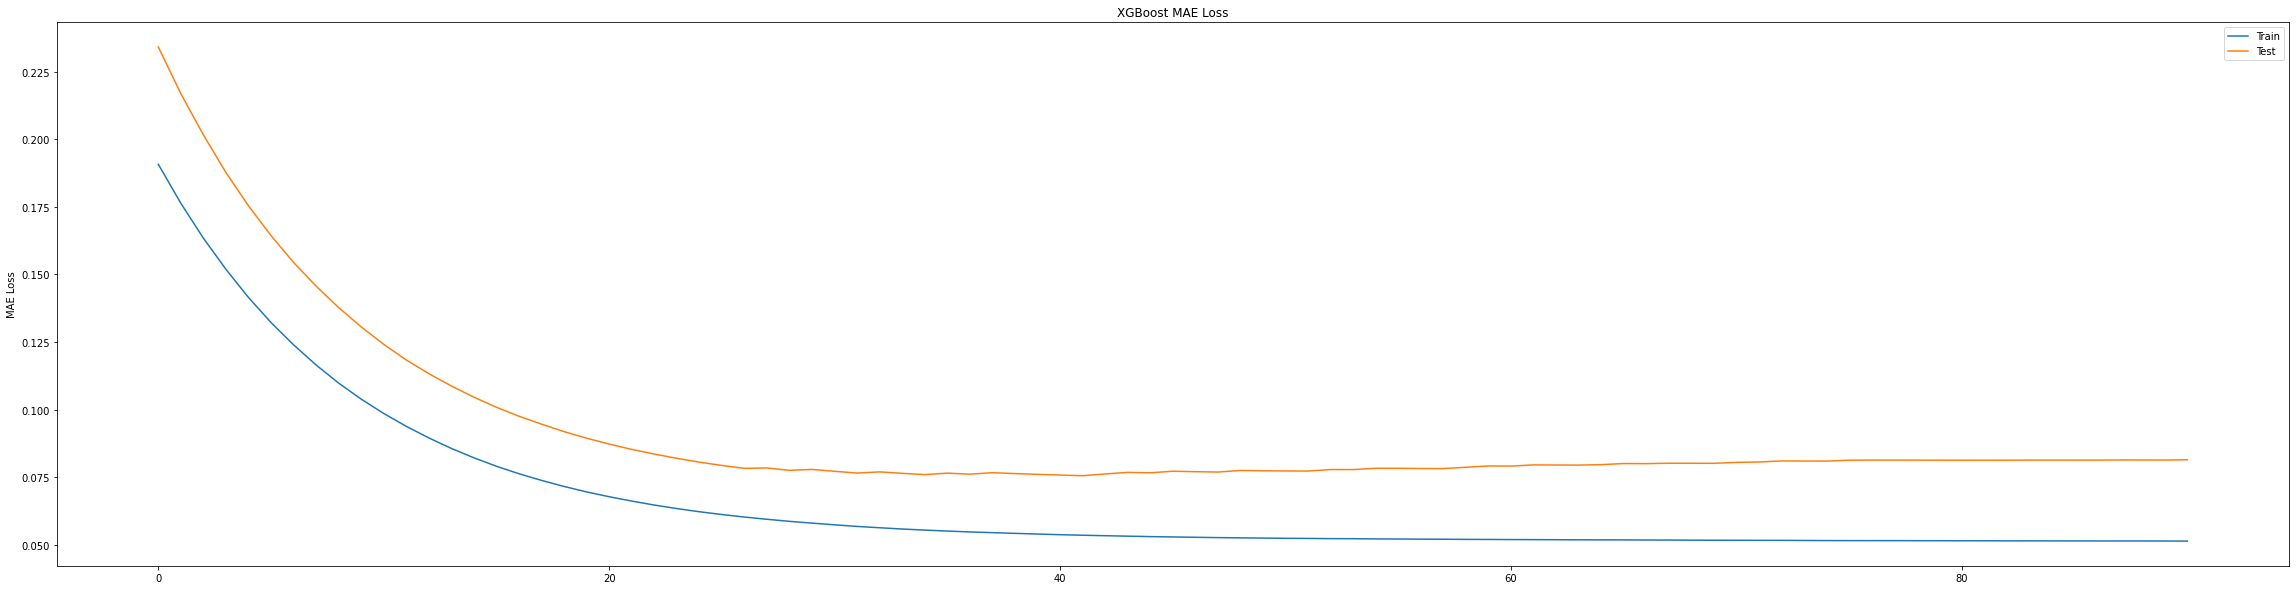

In [ ]:
# window_size = 10, shift = 4
z_train, z_train_out = lag_features(x_train, 'x', shift = 4, window_size=10)
z_test, z_test_out = lag_features(x_test, 'x',shift = 4,  window_size=10)
model = model_experiments(z_train, z_test)
plot_loss(model)